<a href="https://colab.research.google.com/github/amirmosio/MNIST-GAN-Intro/blob/main/CGAN/Session_8_GAN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time

import numpy
import torch
from keras.datasets import mnist
from matplotlib import pyplot
from torch.nn import functional as torch_functional
from torch.utils import data as torch_data_util
import os
import random
torch.manual_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
debug = False
device = "cuda" if torch.cuda.is_available() and not debug else "cpu"
print(device)

mb_size = 200


(train_X, train_y), (test_X, test_y) = mnist.load_data()
(train_X, train_y) = (train_X.astype(numpy.float32), train_y.astype(numpy.float32))
(test_X, test_y) = (test_X.astype(numpy.float32), test_y.astype(numpy.float32))

test_X.shape, test_y.shape

cuda
11501568/11490434 [==============================] - 0s 0us/step


((10000, 28, 28), (10000,))

In [ ]:
generator_train_loader = torch_data_util.DataLoader(train_X, batch_size=mb_size)
generator_train_loader_target = torch_data_util.DataLoader(train_y, batch_size=mb_size)

generator_test_loader = torch_data_util.DataLoader(test_X, batch_size=mb_size)
generator_test_loader_target = torch_data_util.DataLoader(test_y, batch_size=mb_size)
sample_test_X = iter(generator_test_loader).next().to(device)
sample_test_y = iter(generator_test_loader_target).next().to(device)

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.enc = torch.nn.Sequential(  # 1 28 14
        torch.nn.Conv2d(1, 8, (5, 3), stride=(1, 1), padding=0),  # 8 24 12
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2, stride=2, padding=0),  # 8 12 6
        torch.nn.Conv2d(8, 64, (5, 3), stride=(1, 1), padding=0),  # 64 8 4
        torch.nn.LeakyReLU(),
        torch.nn.MaxPool2d(2, stride=2, padding=(0, 0)),  # 64 4 2
        torch.nn.Conv2d(64, 256, (3, 2), stride=(1, 1), padding=0),  # B 256 2 1
        torch.nn.Sigmoid(),

    )
  def forward(self, data):
    return self.enc(data)*128

class Decoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.dec = torch.nn.Sequential(  # 256 2 1
            torch.nn.ConvTranspose2d(256, 64, (6, 3)),  # 64 7 3
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(64, 16, (6, 3)),  # 16 12 5
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(16, 8, (5, 3)),  # 8 16 7
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(8, 4, (5, 3)),  # 4 20 9
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(4, 2, (5, 3)),  # 2 24 11
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(2, 1, (5, 4)),  # 1 28 14
            torch.nn.Tanh()
        )
  def forward(self, data):
    return (self.dec(data)+1)*128
  
class EncoderAndDecoder(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, data):
    enc_data =  self.encoder(data)
    return self.decoder(enc_data)

In [ ]:
def show_generated_on_sample_for_endcoder_decoder(sample_data, result):
    figure = pyplot.figure()
    sample_data = sample_data.to(device)
    result = result.cpu().detach().numpy()
    for i in range(0, 9, 3):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(sample_data[i].cpu().squeeze(0), cmap=pyplot.get_cmap('gray'))
        pyplot.subplot(330 + 2 + i)
        pyplot.imshow(result[i].squeeze(0), cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    pyplot.clf()
    pyplot.close(figure)

def show_training_charts(loss_runs):
    # error chart
    pyplot.plot(loss_runs, color="red")
    pyplot.show()

In [ ]:
right_encoder, right_decoder = Encoder().to(device), Decoder().to(device)
left_encoder, left_decoder = Encoder().to(device), Decoder().to(device) 
encoder_decoder_right_half = EncoderAndDecoder(right_encoder, right_decoder).to(device)
encoder_decoder_left_half = EncoderAndDecoder(left_encoder, left_decoder).to(device)


epoch_numbers = 200
enc_dec_lr = 3e-4

right_opt = torch.optim.Adam(encoder_decoder_right_half.parameters(), lr=enc_dec_lr)
left_opt = torch.optim.Adam(encoder_decoder_left_half.parameters(), lr=enc_dec_lr)

In [ ]:
right_enc_dec_loss_runs = []
left_enc_dec_loss_runs = []

loss_function = torch.nn.MSELoss()
for epoch in range(epoch_numbers):
    epoch_start_time = time.time()

    right_enc_dec_loss_runs.append(0)
    left_enc_dec_loss_runs.append(0)

    batch_number = 0
    for batch_number, data in enumerate(generator_train_loader):
        batch_start_time = time.time()

        data = data.unsqueeze(1).to(device)

        # Training Encoder and Decoder for batch left\right and half image parts
        generated_left_images = encoder_decoder_left_half(data[:, :, :, :14])
        left_real_loss = loss_function(data[:, :, :, :14], generated_left_images)
        left_opt.zero_grad() 
        left_real_loss.backward()  
        left_opt.step()


        generated_right_images = encoder_decoder_right_half(data[:, :, :, 14:])
        right_real_loss = loss_function(data[:, :, :, 14:], generated_right_images)
        right_opt.zero_grad()
        right_real_loss.backward()
        right_opt.step()

        left_enc_dec_loss_runs[-1] += left_real_loss.item()
        right_enc_dec_loss_runs[-1] += right_real_loss.item()

    right_enc_dec_loss_runs[-1] /= (batch_number + 1)
    left_enc_dec_loss_runs[-1] /= (batch_number + 1)

    print("epoch:", epoch, "in: ", int(time.time() - epoch_start_time))

    sample_data_right = sample_test_X.unsqueeze(1)[:, :, :, 14:]
    sample_data_left = sample_test_X.unsqueeze(1)[:, :, :, :14]
    show_generated_on_sample_for_endcoder_decoder(sample_data_right, encoder_decoder_right_half(sample_data_right))
    show_generated_on_sample_for_endcoder_decoder(sample_data_left, encoder_decoder_left_half(sample_data_left))
    
    # save models
    torch.save(right_encoder, "/content/drive/MyDrive/GAN on MNIST/right_encoder.dat")
    torch.save(right_decoder, "/content/drive/MyDrive/GAN on MNIST/right_decoder.dat")
    torch.save(left_encoder, "/content/drive/MyDrive/GAN on MNIST/left_encoder.dat")
    torch.save(left_decoder, "/content/drive/MyDrive/GAN on MNIST/left_decoder.dat")
pyplot.plot(right_enc_dec_loss_runs, color="red")
pyplot.plot(left_enc_dec_loss_runs, color="blue")
pyplot.show()

In [ ]:
right_encoder = torch.load("/content/drive/MyDrive/GAN on MNIST/right_encoder.dat")
right_decoder = torch.load("/content/drive/MyDrive/GAN on MNIST/right_decoder.dat")
left_encoder = torch.load("/content/drive/MyDrive/GAN on MNIST/left_encoder.dat")
left_decoder = torch.load("/content/drive/MyDrive/GAN on MNIST/left_decoder.dat")

# set requres grad to False
for model in [right_encoder, right_decoder, left_encoder, left_decoder]:
  for param in model.parameters():
    param.requires_grad = False

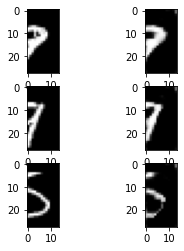

<Figure size 432x288 with 0 Axes>

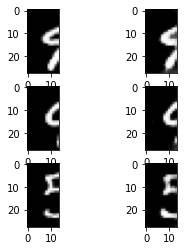

<Figure size 432x288 with 0 Axes>

In [ ]:
right_model = EncoderAndDecoder(right_encoder, right_decoder)
d_right = sample_test_X.unsqueeze(1)[9:, :, :, 14:]
result = right_encoder(d_right)
# print(result)
result = right_decoder(result)
show_generated_on_sample_for_endcoder_decoder(d_right, result)

left_model = EncoderAndDecoder(left_encoder, left_decoder)
d_left = sample_test_X.unsqueeze(1)[9:, :, :, :14]
show_generated_on_sample_for_endcoder_decoder(d_left, left_model(d_left))

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, left_encoder, left_decoder, right_decoder, encode_dim=512, latent_noise_dim=64, lable_vector_dim=10):
        super().__init__()
        self.encoder_sigmoid_coeff = 128
        self.left_encoder = left_encoder
        self.encode_dim = encode_dim

        self.condition_embedding = torch.nn.Sequential(
            torch.nn.Linear(lable_vector_dim, 100),                                               # B 1024
            torch.nn.LeakyReLU(0.2, inplace=True)
        )
        self.extra_dim = latent_noise_dim + 100
        self.generate_encoding_layer = torch.nn.Sequential(
            torch.nn.Linear(self.encode_dim + self.extra_dim, self.encode_dim + (3*self.extra_dim)//4),  # self.encode_dim (3*self.extra_dim)//4
            torch.nn.BatchNorm1d(self.encode_dim + (3*self.extra_dim)//4),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.encode_dim + (3*self.extra_dim)//4, self.encode_dim + (2*self.extra_dim)//4),  # self.encode_dim + (2*self.extra_dim)//4
            torch.nn.BatchNorm1d(self.encode_dim + (2*self.extra_dim)//4),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.encode_dim + (2*self.extra_dim)//4, self.encode_dim + self.extra_dim//4),  # self.encode_dim + 2/4*noise dim
            torch.nn.BatchNorm1d(self.encode_dim + self.extra_dim//4),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.encode_dim + self.extra_dim//4, self.encode_dim),  # self.encode_dim64
            torch.nn.Sigmoid(),
        )
        print("Generator")
        for i,b in self.generate_encoding_layer.named_parameters():
          print(list(b.shape), end="->")
        print()
        self.right_decoder = right_decoder

    def forward(self, left_part, z, labels):
      BATCH_SIZE = left_part.shape[0]
      # with torch.no_grad():
      left_encoded = self.left_encoder(left_part)  
      
      left_encoded_vector = left_encoded.reshape(BATCH_SIZE, -1)

      condition_embedding = self.condition_embedding(labels.to(torch.float))
      
      left_encoded_with_noise = torch.cat([left_encoded_vector, z, condition_embedding], -1)
      right_encoded_vector = self.generate_encoding_layer(left_encoded_with_noise) * self.encoder_sigmoid_coeff
      right_encoded = right_encoded_vector.reshape(BATCH_SIZE, -1, 2, 1)
      print(right_encoded[-1][0][0].item(), end="#")

      # with torch.no_grad():
      right_decoded = self.right_decoder(right_encoded)
      full_image = torch.cat([left_part, right_decoded], -1)
      return full_image


In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, left_encoder, right_encoder, lable_vector_dim=10):
        super().__init__()
        self.left_encoder = left_encoder
        self.right_encoder = right_encoder
        self.extra = lable_vector_dim
        self.features = torch.nn.Sequential(
            torch.nn.Linear(512 * 2 + self.extra, 512 * 2),
            torch.nn.BatchNorm1d(512 * 2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512 * 2, 128 * 2),
            torch.nn.BatchNorm1d(128 * 2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128 * 2, 32 * 2),
            torch.nn.BatchNorm1d(32 * 2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32 * 2, 8 * 2),  # B 128
            torch.nn.BatchNorm1d(8 * 2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(8 * 2, 1),  # B 128
            torch.nn.Sigmoid()
        )
        print("Discriminator")
        for i,b in self.features.named_parameters():
          print(list(b.shape), end="->")
        print()

    def forward(self, input, labels):
        BATCH_SIZE = labels.shape[0]
        # input = input.unsqueeze(1)
        left_vector = self.left_encoder(input[:, :, :, :14]).reshape(BATCH_SIZE, -1)
        right_vector = self.right_encoder(input[:, :, :, 14:]).reshape(BATCH_SIZE, -1)
        input_vector = torch.cat([left_vector, right_vector, labels], 1)
        f = self.features(input_vector)
        return f

In [ ]:
def generate_random_gaussian(batch_size, dim, mean=0, deviation=100):
    return (torch.randn(batch_size, dim) * deviation) + mean


def show_generated_on_sample():
    figure = pyplot.figure()
    data_target_one_hot = torch_functional.one_hot(sample_test_y.to(torch.int64))
    test_left_half = sample_test_X[:, :, :14].unsqueeze(1).to(device)
    BATCH_SIZE = test_left_half.shape[0]
    z = generate_random_gaussian(BATCH_SIZE, initial_random_base_dim).to(device)
    result = generator(test_left_half, z, data_target_one_hot)
    result = result.squeeze(1).cpu().detach().numpy()
    print("\n#########")
    print(sample_test_y[:9])
    print("right", result[:, :, 14:].min(), result[:, :, 14:].mean(), result[:, :, 14:].max())
    print("left", result[:, :, :14].min(), result[:, :, :14].mean(), result[:, :, :14].max())
    fig, axs = pyplot.subplots(2, 9)
    for i in range(0, 18, 2):
      j = i//2
      axs[0, j].imshow(result[j], cmap=pyplot.get_cmap('gray'))

      axs[1, j].imshow(sample_test_X[j].cpu(), cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    pyplot.clf()
    pyplot.close(figure)
  
def show_training_charts():
    # error chart
    pyplot.plot(G_loss_runs, color="blue")
    pyplot.plot(D_loss_runs, color="red")
    pyplot.show()

In [ ]:
initial_random_base_dim = 128
generator = Generator(left_encoder, left_decoder, right_decoder, latent_noise_dim=initial_random_base_dim).to(device)
discriminator = Discriminator(left_encoder, right_encoder).to(device)

d_learning_rate = 3e-4
g_learning_rate = 3e-4
epoch_numbers = 200

g_opt = torch.optim.Adam(generator.parameters(), lr=g_learning_rate)
d_opt = torch.optim.Adam(discriminator.parameters(), lr=d_learning_rate)

Generator
[683, 740]->[683]->[683]->[683]->[626, 683]->[626]->[626]->[626]->[569, 626]->[569]->[569]->[569]->[512, 569]->[512]->
Discriminator
[1024, 1034]->[1024]->[1024]->[1024]->[256, 1024]->[256]->[256]->[256]->[64, 256]->[64]->[64]->[64]->[16, 64]->[16]->[16]->[16]->[1, 16]->[1]->


127.99923706054688#127.999267578125#0.0035718486178666353#0.0033886879682540894#118.72319030761719#118.63081359863281#2.9375674724578857#2.896864175796509#125.3551025390625#125.40972137451172#117.19774627685547#117.23782348632812#59.34123229980469#58.924564361572266#128.0#128.0#128.0#128.0#4.071526200277731e-05#3.9648974052397534e-05#94.21216583251953#95.65978240966797#128.0#128.0#127.99996948242188#127.99996948242188#97.24156188964844#97.47965240478516#87.86087799072266#88.7405776977539#127.99984741210938#127.99984741210938#90.45924377441406#91.21713256835938#128.0#128.0#18.683752059936523#19.562475204467773#1.2298293113708496#1.1925792694091797#128.0#128.0#122.67888641357422#122.77539825439453#127.99998474121094#127.99998474121094#128.0#128.0#127.99653625488281#127.99638366699219#128.0#128.0#128.0#128.0#2.519784927368164#2.6557466983795166#128.0#128.0#127.45423889160156#127.45768737792969#127.99996948242188#127.99996948242188#12.78907585144043#13.685233116149902#125.11763763427734#12

<Figure size 432x288 with 0 Axes>

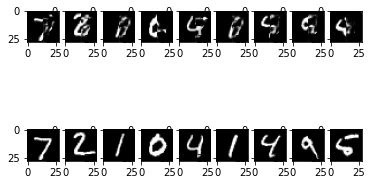

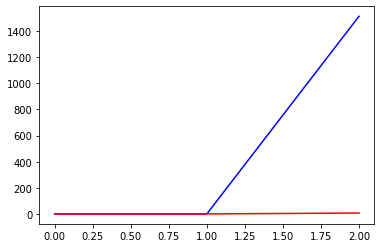

127.41835021972656#127.43946075439453#0.0030892440117895603#0.0035813613794744015#126.14639282226562#126.14929962158203#15.365179061889648#15.108868598937988#8.511334419250488#8.426676750183105#123.18368530273438#123.21088409423828#127.65557861328125#127.68938446044922#128.0#128.0#128.0#128.0#2.5734398150234483e-05#2.539674642321188e-05#127.54915618896484#127.56752014160156#127.99998474121094#127.99998474121094#127.98992919921875#127.99031066894531#127.13085174560547#127.13917541503906#127.33975982666016#127.30152893066406#127.99169921875#127.99177551269531#127.09217834472656#127.10183715820312#128.0#128.0#32.2175178527832#31.72890853881836#0.24125519394874573#0.2412998527288437#128.0#128.0#127.69835662841797#127.69354248046875#127.99905395507812#127.99897766113281#128.0#128.0#126.92494201660156#126.94615936279297#128.0#128.0#128.0#128.0#11.64478588104248#11.851076126098633#128.0#128.0#127.73615264892578#127.73632049560547#127.88091278076172#127.87690734863281#9.543768882751465#9.76645

<Figure size 432x288 with 0 Axes>

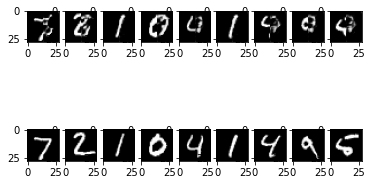

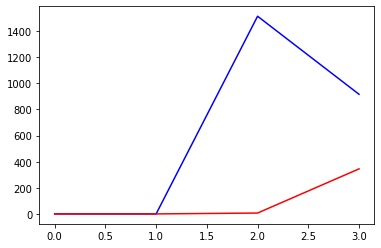

94.1364974975586#93.70794677734375#2.794736385345459#2.7667949199676514#126.83882904052734#126.82147979736328#87.84539794921875#82.84125518798828#72.1518325805664#71.00372314453125#0.2978341281414032#0.25944840908050537#125.84442901611328#125.90857696533203#127.99720764160156#127.99635314941406#127.92289733886719#127.90526580810547#0.004743820521980524#0.004896729253232479#126.94926452636719#126.91921997070312#0.16981694102287292#0.15624266862869263#10.3191556930542#9.224786758422852#126.89440155029297#126.89957427978516#110.8856201171875#110.1603012084961#1.678434133529663#1.6347121000289917#126.36363983154297#126.33489227294922#127.1274642944336#127.20684814453125#0.6733315587043762#0.7093977332115173#111.76163482666016#112.86644744873047#127.27210998535156#127.37250518798828#126.40007019042969#126.46833038330078#0.31080135703086853#0.3254310190677643#126.58332824707031#126.47761535644531#117.71994018554688#118.88324737548828#11.870471000671387#14.847837448120117#127.98269653320312#1

<Figure size 432x288 with 0 Axes>

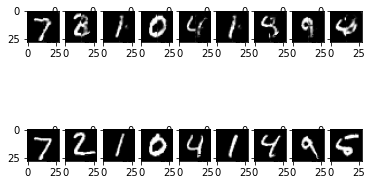

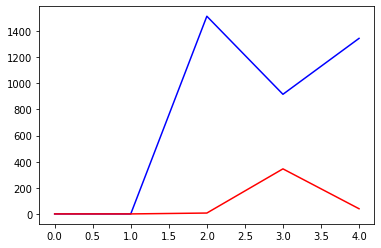

127.09881591796875#127.14471435546875#126.61052703857422#126.6163330078125#70.28136444091797#69.55233001708984#126.6703872680664#126.73777770996094#127.97449493408203#127.97501373291016#127.87503051757812#127.87023162841797#127.83329772949219#127.83892059326172#127.99967956542969#127.99966430664062#127.99952697753906#127.99949645996094#115.78384399414062#115.74810791015625#127.70882415771484#127.71851348876953#125.85147094726562#125.83300018310547#68.80767059326172#66.8676528930664#56.5915641784668#54.3313102722168#127.97472381591797#127.97344207763672#123.71593475341797#123.61843872070312#97.59715270996094#96.28858947753906#99.00477600097656#100.10236358642578#127.61168670654297#127.63633728027344#127.9767837524414#127.97565460205078#127.99884033203125#127.99879455566406#92.62764739990234#90.34919738769531#125.93008422851562#125.99231719970703#18.484434127807617#15.131776809692383#127.86776733398438#127.86225128173828#16.943511962890625#15.97722053527832#127.98606872558594#127.9855957

<Figure size 432x288 with 0 Axes>

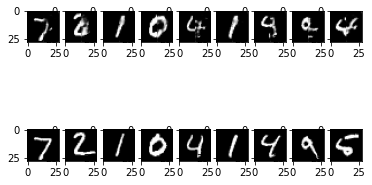

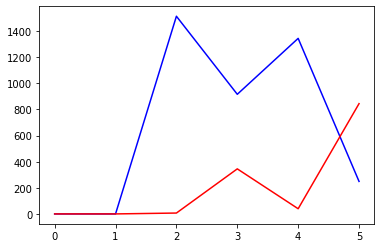

126.32177734375#126.32371520996094#127.86050415039062#127.85741424560547#23.529966354370117#21.632638931274414#127.29430389404297#127.30021667480469#127.91050720214844#127.91036987304688#127.96411895751953#127.96222686767578#108.76300811767578#110.09410095214844#127.9998779296875#127.99986267089844#127.99758911132812#127.99755859375#113.40829467773438#112.50469970703125#127.75836181640625#127.80732727050781#125.9032211303711#125.63925170898438#5.2755126953125#4.976916313171387#1.2720742225646973#1.2878559827804565#127.52202606201172#127.48377990722656#98.82799530029297#95.15007781982422#17.11075210571289#15.30551815032959#0.901599109172821#0.8249411582946777#127.11957550048828#126.95018005371094#127.99960327148438#127.99961853027344#127.99041748046875#127.98886108398438#14.06483268737793#12.449219703674316#122.6086196899414#122.31169128417969#1.362583875656128#1.3926260471343994#127.96112060546875#127.9581298828125#2.7906172275543213#2.6246511936187744#127.92768096923828#127.9222106933

<Figure size 432x288 with 0 Axes>

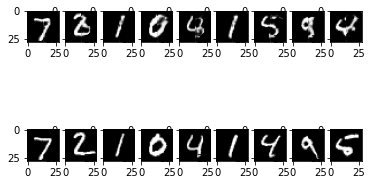

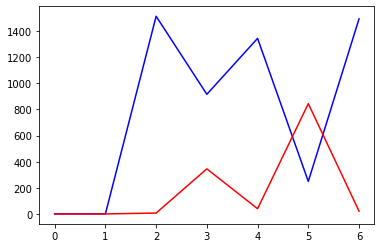

121.64028930664062#121.37406158447266#124.30657958984375#124.43356323242188#6.3482794761657715#6.264126300811768#8.498705863952637#8.501805305480957#127.10499572753906#127.08618927001953#105.31285858154297#105.68204498291016#125.6866683959961#125.75393676757812#127.99362182617188#127.99354553222656#127.9874267578125#127.98738098144531#0.5579476356506348#0.5790554285049438#127.92708587646484#127.9292221069336#6.423467636108398#6.092867374420166#61.11663055419922#60.8699951171875#0.05138425901532173#0.05459216609597206#108.98236846923828#108.71078491210938#5.611968994140625#5.548813343048096#2.8262436389923096#2.8815813064575195#2.4426674842834473#2.4509377479553223#7.805088043212891#7.77119779586792#127.99598693847656#127.99601745605469#127.98789978027344#127.98773193359375#1.5137975215911865#1.533797264099121#1.7438786029815674#1.8215028047561646#24.874784469604492#26.285226821899414#127.26299285888672#127.25426483154297#13.406503677368164#13.67691421508789#64.81950378417969#62.2382812

<Figure size 432x288 with 0 Axes>

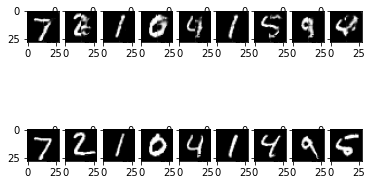

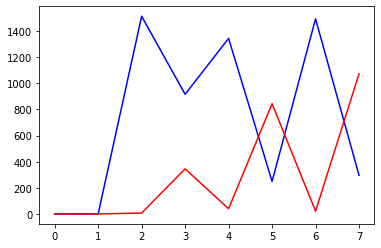

114.63692474365234#114.63609313964844#124.95379638671875#124.95616149902344#14.245205879211426#13.996764183044434#0.14376823604106903#0.1444123387336731#127.28666687011719#127.26329803466797#55.2630729675293#53.97203063964844#126.06974792480469#126.12373352050781#103.6666259765625#106.43586730957031#127.55691528320312#127.61113739013672#21.219629287719727#22.086400985717773#127.999755859375#127.99977111816406#49.75224685668945#48.118553161621094#116.77073669433594#115.01171112060547#2.3442955017089844#2.0063583850860596#66.94483184814453#66.35619354248047#17.442537307739258#16.09532356262207#4.499988079071045#3.9876556396484375#120.25763702392578#119.43878936767578#84.40849304199219#83.23751831054688#127.9984130859375#127.99842834472656#127.96857452392578#127.97640228271484#0.9420141577720642#0.7348973155021667#14.820945739746094#13.413310050964355#121.98921203613281#121.16303253173828#97.86212158203125#96.75039672851562#83.61138916015625#84.16487884521484#0.0018823144491761923#0.00246

<Figure size 432x288 with 0 Axes>

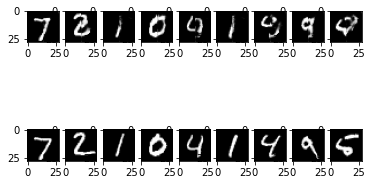

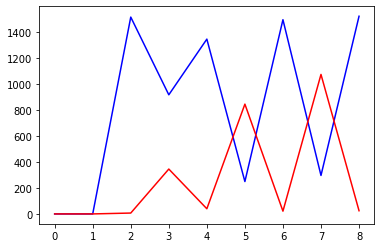

127.35149383544922#127.37530517578125#102.10729217529297#102.12410736083984#92.13297271728516#92.15584564208984#64.9101333618164#65.49647521972656#127.80579376220703#127.78439331054688#127.12088775634766#127.20500946044922#127.83663177490234#127.85305786132812#127.98725891113281#127.98748779296875#127.9610595703125#127.96121215820312#57.3104362487793#57.8150520324707#127.98612976074219#127.9873046875#115.18585968017578#115.9280014038086#0.59727942943573#0.6118019223213196#4.840974807739258#5.608963489532471#56.84421920776367#56.961421966552734#92.1998062133789#92.5311050415039#67.7899169921875#69.45362091064453#99.97290802001953#101.60002899169922#46.74440383911133#47.29125213623047#127.98191833496094#127.9822998046875#127.97972106933594#127.98005676269531#92.47002410888672#92.86548614501953#46.39006042480469#46.06563186645508#110.05598449707031#111.19316864013672#127.96187591552734#127.96231842041016#2.3307852745056152#2.2506306171417236#127.98886108398438#127.9891357421875#49.7053642

<Figure size 432x288 with 0 Axes>

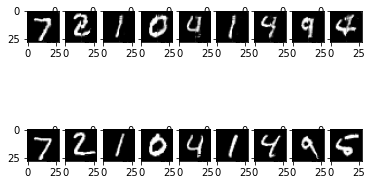

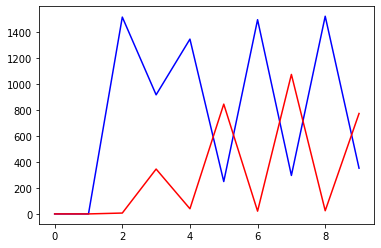

123.99755859375#123.98861694335938#100.3308334350586#99.54450988769531#123.04885864257812#122.73822021484375#126.42239379882812#126.37692260742188#126.7789306640625#126.7822494506836#126.47494506835938#126.38896179199219#127.99949645996094#127.99952697753906#128.0#128.0#127.99983215332031#127.99983215332031#22.24947166442871#21.341588973999023#128.0#128.0#31.717578887939453#28.6879940032959#6.406403064727783#6.286310195922852#127.99070739746094#127.99165344238281#115.00818634033203#115.19808959960938#44.68522644042969#43.80847930908203#127.9757308959961#127.9760971069336#127.99998474121094#127.99998474121094#0.7029977440834045#0.7230492830276489#127.92509460449219#127.92827606201172#127.99948120117188#127.99954223632812#125.91519165039062#125.93373107910156#1.2255421876907349#1.1906670331954956#127.95967102050781#127.95765686035156#127.94414520263672#127.94020080566406#2.418032646179199#2.4252963066101074#127.99998474121094#127.99998474121094#103.31889343261719#103.2991714477539#125.68

<Figure size 432x288 with 0 Axes>

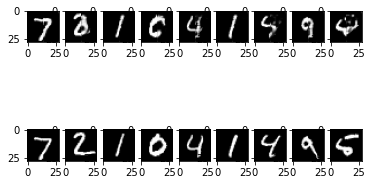

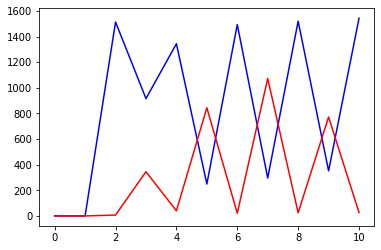

127.99755859375#127.99749755859375#127.99313354492188#127.99317932128906#119.49703979492188#119.53206634521484#125.77481079101562#125.77105712890625#127.9750747680664#127.97452545166016#127.99656677246094#127.99653625488281#127.88619232177734#127.88729095458984#128.0#128.0#127.99983215332031#127.99983215332031#127.96973419189453#127.9699478149414#128.0#128.0#127.88797760009766#127.88671112060547#127.84272003173828#127.84025573730469#127.9993896484375#127.99940490722656#127.71806335449219#127.72080993652344#127.88935089111328#127.8875503540039#125.8761978149414#125.92754364013672#128.0#128.0#127.96075439453125#127.9609375#127.98066711425781#127.98052978515625#127.99986267089844#127.99984741210938#121.9012680053711#121.96549987792969#127.7331314086914#127.73454284667969#127.9998779296875#127.9998779296875#127.99948120117188#127.99948120117188#105.20973205566406#105.3189468383789#127.99971008300781#127.99969482421875#121.81952667236328#121.83840942382812#127.829833984375#127.8299713134765

<Figure size 432x288 with 0 Axes>

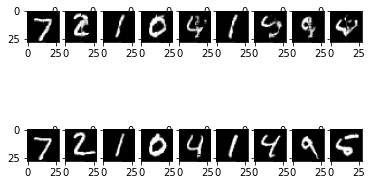

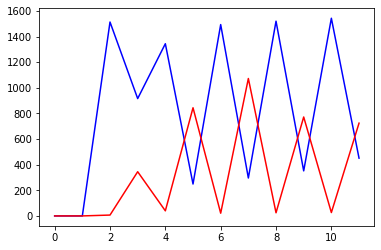

127.8805160522461#127.88082122802734#127.99739074707031#127.99739074707031#121.22260284423828#121.19173431396484#127.03726196289062#127.04325866699219#126.96397399902344#126.95783233642578#127.99906921386719#127.99911499023438#127.99903869628906#127.99903869628906#127.99992370605469#127.99992370605469#127.98834228515625#127.98847961425781#127.99151611328125#127.99156188964844#128.0#128.0#127.94998931884766#127.95156860351562#127.9849853515625#127.98469543457031#128.0#128.0#127.79022979736328#127.79249572753906#127.29711151123047#127.2882080078125#127.9465103149414#127.94841766357422#127.99847412109375#127.99842834472656#127.86479949951172#127.86246490478516#127.96000671386719#127.9625015258789#127.99980163574219#127.99980163574219#127.4738998413086#127.50531005859375#127.74990844726562#127.74771881103516#127.99983215332031#127.99981689453125#127.99156188964844#127.99142456054688#127.07067108154297#127.1236572265625#127.99923706054688#127.999267578125#125.65089416503906#125.634552001953

<Figure size 432x288 with 0 Axes>

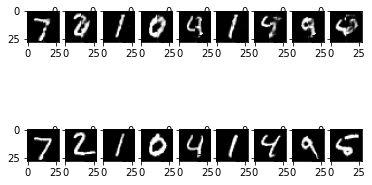

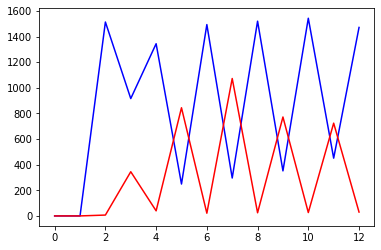

106.0213394165039#106.49581909179688#126.3511962890625#126.23147583007812#125.30000305175781#125.24198150634766#127.14330291748047#127.1448974609375#127.4410171508789#127.45137023925781#123.29841613769531#123.25765991210938#127.90784454345703#127.90857696533203#128.0#128.0#127.99955749511719#127.99955749511719#127.99766540527344#127.99761962890625#128.0#128.0#5.5454020500183105#5.497590065002441#128.0#128.0#127.90908813476562#127.90709686279297#126.87800598144531#126.86226654052734#49.42180633544922#49.263763427734375#118.4119644165039#118.31797790527344#127.7724380493164#127.77281951904297#10.4713716506958#10.504355430603027#127.99565124511719#127.99565124511719#127.99996948242188#127.99996948242188#124.14005279541016#124.10758209228516#2.148747205734253#2.1421115398406982#127.99977111816406#127.99978637695312#112.56828308105469#112.49104309082031#28.205753326416016#27.860942840576172#127.99993896484375#127.99993896484375#123.57861328125#123.53861999511719#127.88652801513672#127.88661

<Figure size 432x288 with 0 Axes>

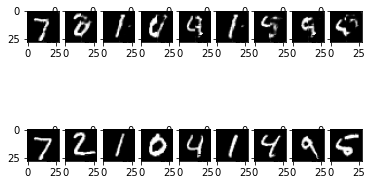

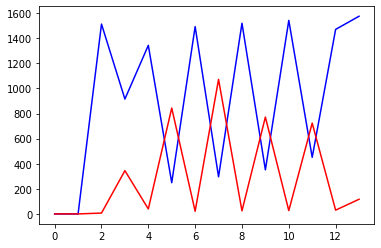

124.56983947753906#124.57376861572266#57.548282623291016#56.41215515136719#123.18888854980469#123.23387908935547#126.1607666015625#126.1351318359375#123.13756561279297#123.05303192138672#127.2931137084961#127.28825378417969#127.8009262084961#127.79891204833984#127.99998474121094#127.99998474121094#127.99797058105469#127.99797058105469#127.26243591308594#127.23164367675781#128.0#128.0#124.46383666992188#124.53317260742188#127.99993896484375#127.99993896484375#127.93559265136719#127.93638610839844#126.22356414794922#126.2213363647461#111.55226135253906#111.71564483642578#116.7103042602539#116.74972534179688#127.95570373535156#127.95660400390625#117.59953308105469#117.81918334960938#127.99911499023438#127.99911499023438#127.99998474121094#127.99998474121094#118.82417297363281#118.85498046875#114.40875244140625#114.79854583740234#128.0#128.0#126.50283813476562#126.52766418457031#13.690144538879395#13.808406829833984#127.99998474121094#127.99998474121094#110.09054565429688#110.1122665405273

<Figure size 432x288 with 0 Axes>

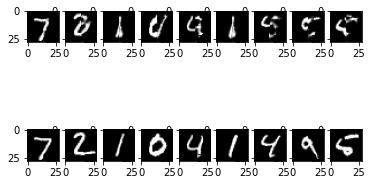

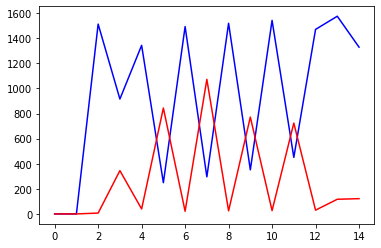

126.84249877929688#126.83975982666016#45.495975494384766#44.18968200683594#120.587646484375#120.57347869873047#127.0871353149414#127.02811431884766#120.99651336669922#120.91311645507812#127.7084732055664#127.70701599121094#103.71973419189453#104.181884765625#128.0#128.0#127.99964904785156#127.9996337890625#54.65574264526367#54.351837158203125#128.0#128.0#127.92445373535156#127.92301940917969#127.98741149902344#127.98623657226562#127.98210144042969#127.98284912109375#127.70314025878906#127.70318603515625#127.17198944091797#127.16757202148438#126.85369873046875#126.87708282470703#127.99832153320312#127.99839782714844#125.32755279541016#125.3800048828125#127.99919128417969#127.99920654296875#127.99995422363281#127.99995422363281#122.54649353027344#122.60968780517578#127.76903533935547#127.77017211914062#127.99998474121094#127.99998474121094#127.67639923095703#127.67857360839844#81.64714050292969#81.67798614501953#127.99998474121094#127.99998474121094#124.34711456298828#124.37345886230469#

<Figure size 432x288 with 0 Axes>

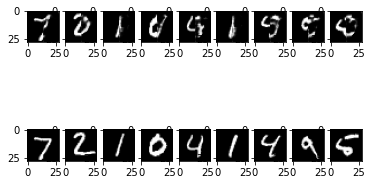

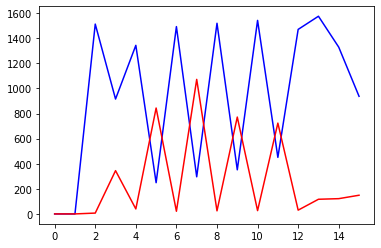

124.92813110351562#124.89593505859375#115.04077911376953#114.99002075195312#126.22862243652344#126.22196197509766#127.47607421875#127.45885467529297#106.92594146728516#106.98893737792969#127.97716522216797#127.97692108154297#127.20967102050781#127.23291015625#128.0#128.0#127.99932861328125#127.99932861328125#108.86170959472656#109.14073181152344#128.0#128.0#127.96756744384766#127.96784210205078#127.99986267089844#127.9998779296875#127.99887084960938#127.99887084960938#127.99050903320312#127.99043273925781#127.58007049560547#127.58231353759766#127.8554458618164#127.85535430908203#127.99998474121094#127.99998474121094#127.65789794921875#127.66199493408203#127.99989318847656#127.9998779296875#127.99995422363281#127.99995422363281#126.77149963378906#126.76720428466797#127.95742797851562#127.95803833007812#128.0#128.0#127.10275268554688#127.09831237792969#126.29689025878906#126.31993865966797#128.0#128.0#127.02546691894531#127.0301284790039#127.9998779296875#127.9998779296875#122.6290283203

<Figure size 432x288 with 0 Axes>

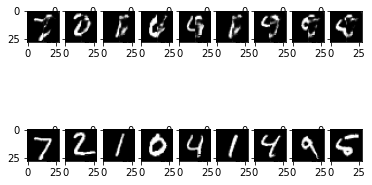

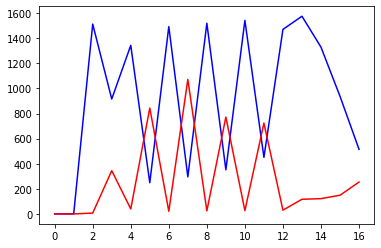

126.85053253173828#126.841796875#125.42440795898438#125.44255065917969#127.59252166748047#127.58572387695312#126.87924194335938#126.9258804321289#116.15876770019531#116.31632232666016#127.96772003173828#127.96776580810547#127.89328002929688#127.89312744140625#127.99998474121094#127.99998474121094#127.99395751953125#127.99403381347656#126.6175537109375#126.60758209228516#128.0#128.0#127.98887634277344#127.98905944824219#127.99992370605469#127.99992370605469#127.99996948242188#127.99996948242188#127.98051452636719#127.98092651367188#127.75038146972656#127.75269317626953#127.93475341796875#127.93475341796875#127.9998779296875#127.9998779296875#127.93201446533203#127.9323959350586#128.0#128.0#127.99995422363281#127.99995422363281#127.76210021972656#127.76223754882812#127.96344757080078#127.96395111083984#128.0#128.0#127.67768096923828#127.67916870117188#127.45006561279297#127.45480346679688#128.0#128.0#126.47080993652344#126.48177337646484#127.99940490722656#127.99942016601562#126.44338989

<Figure size 432x288 with 0 Axes>

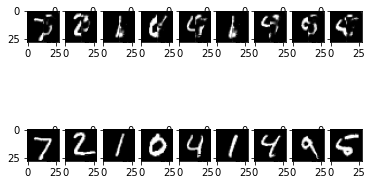

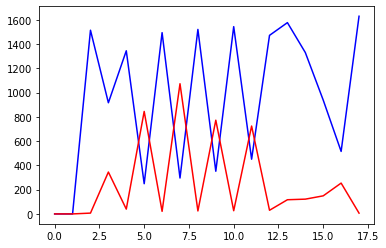

126.09306335449219#126.11251068115234#126.91788482666016#126.92835998535156#127.84101867675781#127.8436508178711#127.24613189697266#127.25261688232422#123.12348937988281#123.15603637695312#127.96208953857422#127.96231842041016#127.90048217773438#127.89993286132812#127.99998474121094#127.99996948242188#127.99957275390625#127.99958801269531#127.03263854980469#127.03585052490234#128.0#128.0#127.99815368652344#127.99815368652344#127.98454284667969#127.984375#127.99998474121094#127.99998474121094#127.99818420410156#127.99821472167969#127.95547485351562#127.95626831054688#127.90180969238281#127.9017333984375#128.0#128.0#127.92748260498047#127.92700958251953#127.99996948242188#127.99996948242188#128.0#128.0#127.75437927246094#127.75349426269531#127.99307250976562#127.99311828613281#128.0#128.0#127.74174499511719#127.74401092529297#127.98124694824219#127.98136901855469#128.0#128.0#127.89620208740234#127.89664459228516#127.99996948242188#127.99996948242188#126.51341247558594#126.52023315429688#

<Figure size 432x288 with 0 Axes>

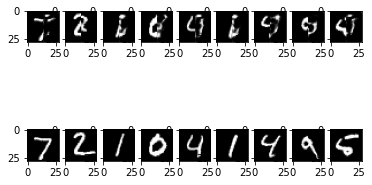

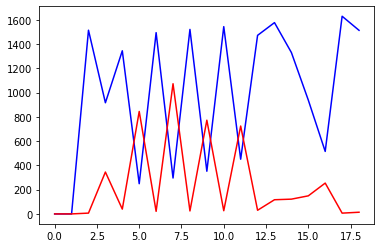

127.79560089111328#127.80364990234375#125.1781997680664#124.9673080444336#127.99824523925781#127.99821472167969#127.9161148071289#127.91600799560547#127.28153991699219#127.30399322509766#127.99934387207031#127.99935913085938#126.58243560791016#126.5076675415039#128.0#127.99998474121094#127.99986267089844#127.99984741210938#127.57894897460938#127.58316802978516#128.0#128.0#127.99992370605469#127.99992370605469#127.99784851074219#127.99784851074219#127.99998474121094#127.99998474121094#127.99491882324219#127.99464416503906#127.99884033203125#127.99884033203125#127.8059310913086#127.80831909179688#128.0#128.0#127.99296569824219#127.99247741699219#127.8981704711914#127.89771270751953#128.0#128.0#127.71720886230469#127.71929168701172#127.99972534179688#127.99971008300781#128.0#128.0#127.93833923339844#127.938232421875#127.98020935058594#127.98014831542969#127.99990844726562#127.99989318847656#127.60355377197266#127.59805297851562#127.99998474121094#127.99998474121094#125.71650695800781#125.

<Figure size 432x288 with 0 Axes>

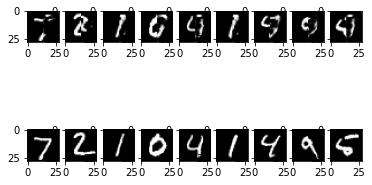

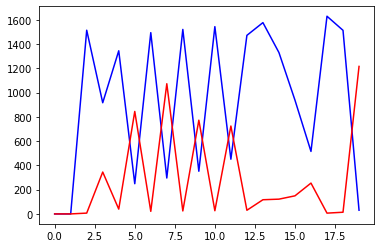

127.96067810058594#127.96070861816406#122.9803695678711#122.98226928710938#127.986328125#127.98635864257812#127.52338409423828#127.51342010498047#126.96350860595703#126.92372131347656#127.99945068359375#127.99946594238281#125.99885559082031#125.99559783935547#127.99996948242188#127.99996948242188#127.99772644042969#127.99772644042969#127.21035766601562#127.20545959472656#128.0#128.0#127.99990844726562#127.99992370605469#127.99729919433594#127.9971923828125#127.99998474121094#127.99998474121094#127.97736358642578#127.97753143310547#127.99908447265625#127.99908447265625#127.86613464355469#127.86527252197266#128.0#128.0#127.99417114257812#127.994140625#127.95323181152344#127.95367431640625#127.99996948242188#127.99996948242188#127.71155548095703#127.71107482910156#127.99983215332031#127.99983215332031#128.0#128.0#127.95167541503906#127.95242309570312#127.9813232421875#127.98141479492188#127.99916076660156#127.9991455078125#126.564453125#126.57582092285156#127.99992370605469#127.9999237060

<Figure size 432x288 with 0 Axes>

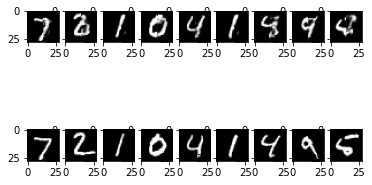

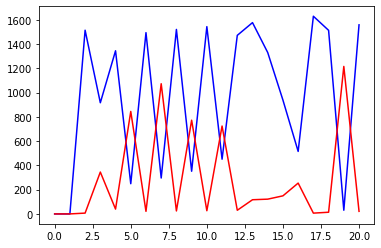

125.6689682006836#125.72702026367188#127.99736022949219#127.997314453125#127.99996948242188#127.99996948242188#127.94629669189453#127.94470977783203#127.9747543334961#127.97466278076172#127.95626831054688#127.95634460449219#127.79231262207031#127.79324340820312#127.9996337890625#127.99960327148438#127.99942016601562#127.99934387207031#127.99789428710938#127.99784851074219#128.0#128.0#126.73225402832031#126.63005828857422#128.0#128.0#127.98809814453125#127.98788452148438#127.95869445800781#127.95759582519531#126.16972351074219#126.12982940673828#127.98907470703125#127.988525390625#128.0#128.0#124.5160140991211#124.43013000488281#128.0#128.0#127.99296569824219#127.99235534667969#127.96691131591797#127.96639251708984#123.86944580078125#123.88121795654297#128.0#128.0#126.83077239990234#126.89028930664062#124.65704345703125#124.61495971679688#127.99981689453125#127.99981689453125#127.88337707519531#127.88204956054688#127.94044494628906#127.93980407714844#127.951171875#127.95169067382812#127

<Figure size 432x288 with 0 Axes>

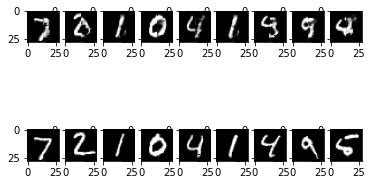

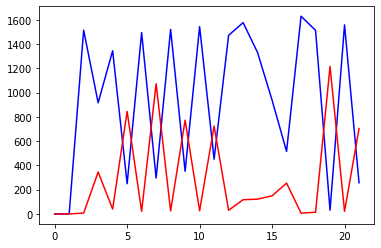

124.7520980834961#124.74864959716797#127.99708557128906#127.99713134765625#128.0#128.0#127.03792572021484#127.06929016113281#127.85521697998047#127.85322570800781#127.94786834716797#127.94438934326172#127.70083618164062#127.72545623779297#127.98556518554688#127.98573303222656#127.983642578125#127.98374938964844#127.99333190917969#127.99354553222656#127.99998474121094#127.99998474121094#125.44328308105469#125.33883666992188#128.0#128.0#127.9758529663086#127.97769927978516#127.89583587646484#127.89672088623047#126.67195892333984#126.61891174316406#127.99685668945312#127.9969482421875#128.0#128.0#127.19383239746094#127.21631622314453#128.0#128.0#127.9717788696289#127.97237396240234#127.99142456054688#127.99154663085938#124.83235168457031#124.91425323486328#128.0#128.0#127.58627319335938#127.62554931640625#124.56694793701172#124.7000732421875#127.99813842773438#127.99800109863281#127.81373596191406#127.8165512084961#127.92462158203125#127.92634582519531#127.989013671875#127.98908996582031#

<Figure size 432x288 with 0 Axes>

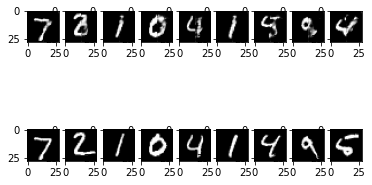

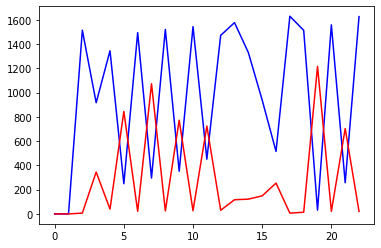

119.71226501464844#119.48014068603516#104.76419067382812#104.910400390625#46.880645751953125#45.749053955078125#43.562461853027344#44.148216247558594#127.98040771484375#127.98077392578125#81.0504379272461#81.51760864257812#37.32421875#37.38235092163086#127.85123443603516#127.85649871826172#127.99923706054688#127.99925231933594#0.07519195228815079#0.07690702378749847#127.99885559082031#127.99880981445312#95.40159606933594#95.47514343261719#127.9937744140625#127.99398803710938#2.135812282562256#2.0594289302825928#126.84386444091797#126.83039855957031#126.95964813232422#126.9677734375#29.56850242614746#29.104032516479492#88.63270568847656#87.5037612915039#76.01209259033203#76.81156921386719#127.99998474121094#127.99998474121094#126.28196716308594#126.33843994140625#23.713911056518555#23.668493270874023#60.75251007080078#61.28136444091797#123.27140045166016#123.15560150146484#127.998046875#127.99806213378906#5.788819789886475#5.823238849639893#110.65929412841797#110.69318389892578#123.5523

<Figure size 432x288 with 0 Axes>

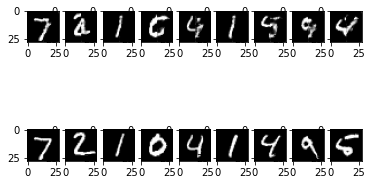

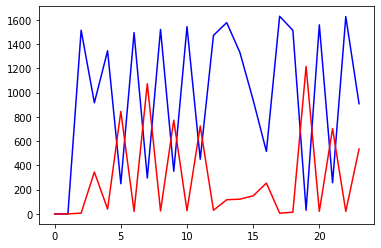

127.99969482421875#127.99969482421875#20.76310157775879#20.71101951599121#51.77503967285156#51.63662338256836#21.63460922241211#20.77875518798828#127.97464752197266#127.97611236572266#127.99928283691406#127.99928283691406#98.87933349609375#98.35765838623047#127.96136474609375#127.95814514160156#127.99652099609375#127.99630737304688#1.9191303253173828#1.9686567783355713#127.99137878417969#127.99110412597656#127.99935913085938#127.99937438964844#127.99855041503906#127.99851989746094#5.471959114074707#5.723072052001953#119.29400634765625#119.07571411132812#127.99853515625#127.99859619140625#29.947532653808594#31.43946075439453#2.7995152473449707#3.2966830730438232#127.99781799316406#127.99794006347656#127.99998474121094#127.99998474121094#127.85887145996094#127.82042694091797#84.7619400024414#86.05079650878906#127.99862670898438#127.99876403808594#115.77460479736328#118.40253448486328#128.0#128.0#109.31787872314453#109.1404037475586#0.7391027212142944#0.5906035304069519#88.23372650146484#

<Figure size 432x288 with 0 Axes>

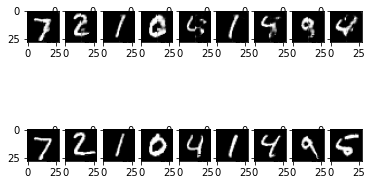

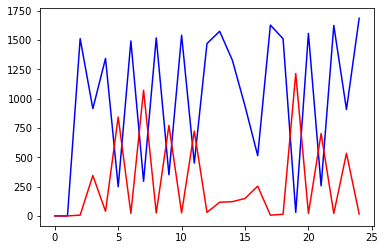

103.78289031982422#101.78724670410156#85.5208740234375#82.69890594482422#70.548583984375#69.50993347167969#26.189565658569336#24.631908416748047#127.14543914794922#127.08995056152344#125.23986053466797#124.84964752197266#126.68531799316406#126.7474136352539#127.97774505615234#127.97807312011719#127.99520874023438#127.99520874023438#9.871238708496094#9.331302642822266#127.99903869628906#127.99909973144531#4.720788478851318#4.267777442932129#127.84626770019531#127.858642578125#113.46136474609375#113.49076843261719#122.3578872680664#122.49681854248047#33.49192810058594#32.429771423339844#106.913818359375#107.38485717773438#123.43640899658203#123.6585693359375#1.335754632949829#1.174558162689209#127.99995422363281#127.99995422363281#127.98866271972656#127.98886108398438#83.90013122558594#84.18447875976562#0.38941022753715515#0.36115527153015137#127.81867980957031#127.8261947631836#127.99713134765625#127.9970703125#5.12830114364624#5.31719446182251#106.18854522705078#103.5040283203125#119.4

<Figure size 432x288 with 0 Axes>

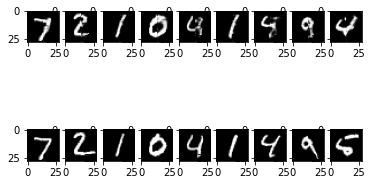

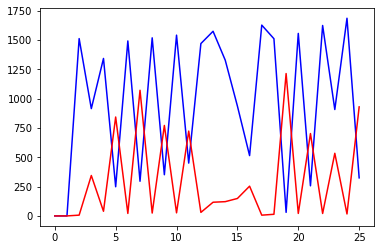

9.348406791687012#9.311956405639648#88.45335388183594#87.92157745361328#117.37405395507812#117.24992370605469#99.67315673828125#99.30604553222656#116.58558654785156#116.7623519897461#22.706680297851562#22.164878845214844#127.99473571777344#127.99473571777344#127.99588012695312#127.995849609375#127.82830810546875#127.82601165771484#15.141374588012695#14.359278678894043#128.0#128.0#0.3608027398586273#0.3436064124107361#127.91432189941406#127.91609954833984#115.65379333496094#115.45089721679688#124.70460510253906#124.69194793701172#22.575654983520508#22.38496208190918#125.34748077392578#125.34738159179688#127.49005889892578#127.4629135131836#0.19419309496879578#0.18624503910541534#127.99998474121094#127.99998474121094#127.85496520996094#127.8576431274414#106.17244720458984#105.71428680419922#0.07393046468496323#0.07431578636169434#127.98602294921875#127.98468017578125#127.9690933227539#127.96697235107422#27.81706428527832#26.52358055114746#126.06718444824219#125.95438385009766#123.1280059

<Figure size 432x288 with 0 Axes>

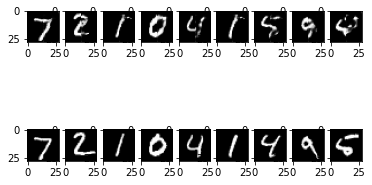

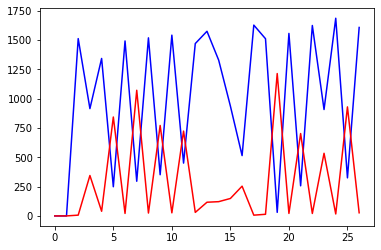

121.1249008178711#121.48905944824219#22.936603546142578#22.64616584777832#18.692363739013672#18.744327545166016#114.99604034423828#114.58214569091797#127.46726989746094#127.46321105957031#127.98265075683594#127.98312377929688#127.02931213378906#126.998291015625#127.99317932128906#127.99263000488281#127.57931518554688#127.55994415283203#8.276288032531738#8.23792552947998#122.63658905029297#122.52428436279297#123.93011474609375#124.29312133789062#127.99107360839844#127.99160766601562#0.0018053294625133276#0.0017672592075541615#123.94087219238281#123.84191131591797#123.35810089111328#123.5450439453125#7.540805816650391#7.505720615386963#7.659575462341309#7.4893388748168945#127.4896240234375#127.51331329345703#127.99708557128906#127.99710083007812#127.91854095458984#127.9177017211914#29.722015380859375#29.397964477539062#125.53233337402344#125.62822723388672#47.080177307128906#46.57080078125#127.9984130859375#127.99842834472656#1.553141713142395#1.5819556713104248#127.97869873046875#127.97

<Figure size 432x288 with 0 Axes>

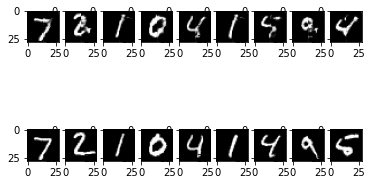

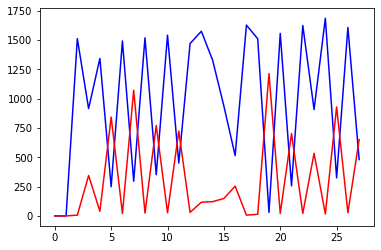

127.98835754394531#127.98828125#49.17730712890625#49.28854751586914#72.85467529296875#72.44129180908203#122.40353393554688#122.36031341552734#127.7430419921875#127.74552917480469#127.99479675292969#127.99476623535156#123.72854614257812#123.80508422851562#127.9623794555664#127.96080017089844#127.26658630371094#127.26050567626953#26.30609703063965#26.91905975341797#127.96268463134766#127.96587371826172#127.85429382324219#127.8531494140625#127.98934936523438#127.98883056640625#7.74408363213297e-07#8.308996370942623e-07#118.26537322998047#118.53382110595703#127.57514190673828#127.60614776611328#4.489614486694336#4.6531853675842285#0.009154727682471275#0.01173130702227354#127.80449676513672#127.8236083984375#127.997314453125#127.99748229980469#127.74626159667969#127.75407409667969#31.83287811279297#33.7668342590332#127.91771697998047#127.92347717285156#71.5832290649414#77.79901123046875#127.97069549560547#127.97241973876953#93.6794204711914#93.88668060302734#127.99073791503906#127.990631103

<Figure size 432x288 with 0 Axes>

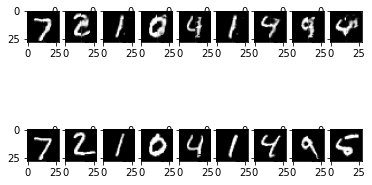

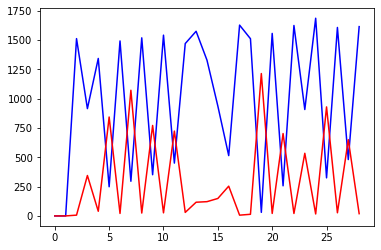

127.63650512695312#127.60869598388672#125.32246398925781#125.3247299194336#113.05675506591797#113.06633758544922#121.54188537597656#121.33168029785156#127.20223999023438#127.12886047363281#127.99800109863281#127.99786376953125#127.75021362304688#127.75695037841797#127.8697280883789#127.8638687133789#126.42699432373047#126.36653137207031#118.94485473632812#118.95975494384766#128.0#128.0#126.4964599609375#126.37178039550781#127.99897766113281#127.99893188476562#124.97915649414062#125.05675506591797#122.98709869384766#122.94721984863281#122.55867767333984#122.30583953857422#127.25230407714844#127.26416015625#127.65303039550781#127.65345001220703#126.94186401367188#126.90975952148438#127.9991455078125#127.9991455078125#124.41126251220703#124.34803771972656#123.52332305908203#123.51747131347656#125.80986785888672#125.76261138916016#127.99539184570312#127.99545288085938#127.9645767211914#127.96430206298828#2.999507427215576#2.938019275665283#127.97869873046875#127.97862243652344#122.93506622

<Figure size 432x288 with 0 Axes>

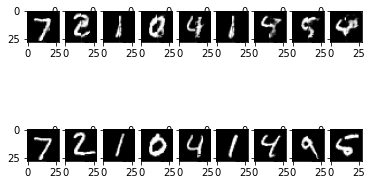

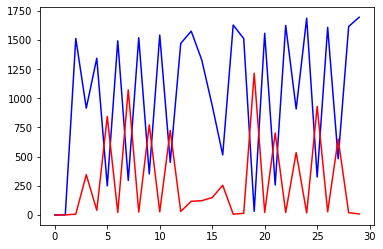

127.48468780517578#127.48796081542969#127.86790466308594#127.86776733398438#112.63606262207031#112.74632263183594#126.92809295654297#126.93338775634766#126.54631805419922#126.5481185913086#127.99697875976562#127.99699401855469#127.2553482055664#127.24545288085938#127.97217559814453#127.97212982177734#127.75030517578125#127.75165557861328#127.40296173095703#127.40410614013672#128.0#128.0#126.96175384521484#126.96363067626953#127.98524475097656#127.98562622070312#125.87067413330078#125.8720932006836#127.09962463378906#127.10406494140625#122.52302551269531#122.5587158203125#123.77536010742188#123.71648406982422#127.97684478759766#127.97672271728516#127.73004913330078#127.73121643066406#127.99995422363281#127.99995422363281#126.84516906738281#126.84467315673828#115.05143737792969#114.99652862548828#127.53443145751953#127.53494262695312#127.99925231933594#127.99925231933594#127.99208068847656#127.99217224121094#1.8644381761550903#1.8746272325515747#127.99064636230469#127.99063110351562#126.

<Figure size 432x288 with 0 Axes>

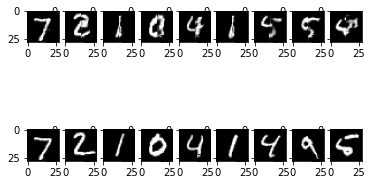

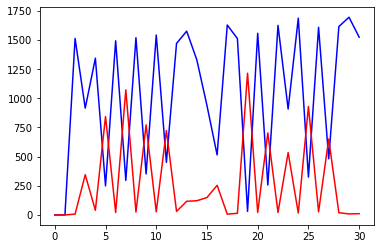

127.82556915283203#127.82691192626953#127.95387268066406#127.95445251464844#117.05403900146484#117.11632537841797#127.74535369873047#127.74554443359375#127.93209075927734#127.93311309814453#127.99919128417969#127.99919128417969#121.56471252441406#121.56464385986328#127.99148559570312#127.991455078125#127.95791625976562#127.95787048339844#127.38072967529297#127.37923431396484#128.0#128.0#127.38760375976562#127.3852310180664#127.99710083007812#127.99708557128906#124.63029479980469#124.58589935302734#127.68022918701172#127.68182373046875#127.33155822753906#127.3314208984375#93.89797973632812#93.80782318115234#127.989013671875#127.98893737792969#127.93879699707031#127.93843078613281#127.99993896484375#127.99993896484375#127.48915100097656#127.49016571044922#118.44344329833984#118.45460510253906#127.73526000976562#127.73452758789062#127.9990234375#127.99900817871094#127.999755859375#127.999755859375#9.148741722106934#9.198466300964355#127.99720764160156#127.99722290039062#127.49903869628906

<Figure size 432x288 with 0 Axes>

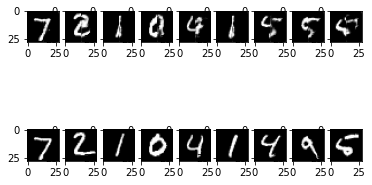

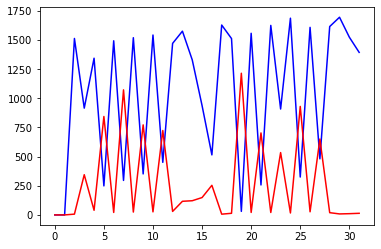

127.84220886230469#127.84285736083984#127.99880981445312#127.99880981445312#116.90926361083984#116.91828155517578#127.9586181640625#127.95912170410156#127.98751831054688#127.98739624023438#127.99774169921875#127.99774169921875#121.34540557861328#121.40142822265625#127.99650573730469#127.99655151367188#127.97533416748047#127.97545623779297#127.9603271484375#127.96134948730469#128.0#128.0#126.84415435791016#126.8479995727539#127.9989013671875#127.9989013671875#127.82269287109375#127.82649993896484#127.9316635131836#127.93169403076172#126.42202758789062#126.41810607910156#118.80805206298828#118.95149230957031#127.98905944824219#127.98895263671875#127.90243530273438#127.90109252929688#127.99978637695312#127.99978637695312#127.7910385131836#127.79027557373047#124.68841552734375#124.6832504272461#127.34767150878906#127.3425521850586#127.999267578125#127.99928283691406#127.99513244628906#127.99507141113281#49.76579666137695#49.930545806884766#127.99574279785156#127.99571228027344#127.57711791

<Figure size 432x288 with 0 Axes>

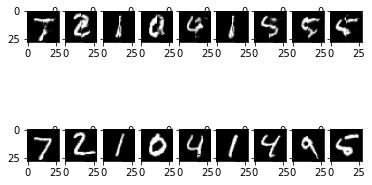

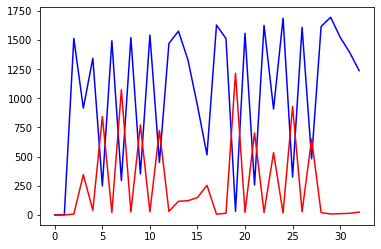

123.7408218383789#123.65914154052734#127.99856567382812#127.99853515625#121.47118377685547#121.47930145263672#127.98149108886719#127.98139953613281#127.9820556640625#127.98185729980469#127.97638702392578#127.97623443603516#124.5394287109375#124.6834945678711#127.99809265136719#127.99807739257812#127.99165344238281#127.99160766601562#127.99969482421875#127.99969482421875#127.99995422363281#127.99995422363281#84.13446044921875#82.74454498291016#127.99015808105469#127.98919677734375#127.96988677978516#127.96991729736328#127.95535278320312#127.95497131347656#114.23340606689453#113.8176040649414#126.44572448730469#126.45561218261719#127.97959899902344#127.97941589355469#120.24199676513672#119.85865783691406#127.9979248046875#127.99794006347656#127.94032287597656#127.93966674804688#126.63302612304688#126.64277648925781#62.83150100708008#60.882896423339844#127.9979248046875#127.99790954589844#127.88166809082031#127.87825775146484#66.7540283203125#66.23632049560547#127.99667358398438#127.99667

<Figure size 432x288 with 0 Axes>

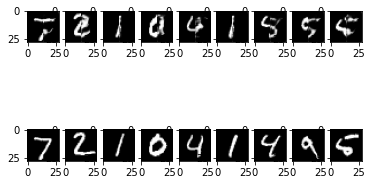

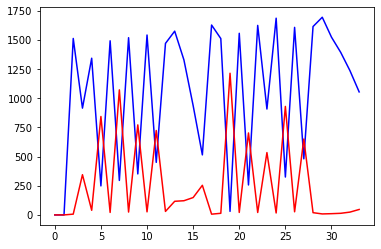

38.62160110473633#37.39252471923828#127.99853515625#127.99850463867188#125.86695861816406#125.87905883789062#127.96150207519531#127.96110534667969#127.98605346679688#127.98570251464844#126.7222671508789#126.5461654663086#124.1580581665039#124.15621948242188#127.99929809570312#127.99928283691406#127.99734497070312#127.99739074707031#127.99948120117188#127.99946594238281#127.99861145019531#127.99862670898438#3.1515309810638428#2.98103666305542#127.99006652832031#127.99101257324219#127.9903564453125#127.990966796875#127.89543914794922#127.8971176147461#67.20061492919922#67.04350280761719#127.380859375#127.38704681396484#127.9726791381836#127.97249603271484#6.94435977935791#6.7880120277404785#127.9998779296875#127.9998779296875#127.9222412109375#127.92527770996094#126.67433166503906#126.68207550048828#1.893378734588623#1.8597393035888672#127.9974365234375#127.99736022949219#106.27706146240234#106.0298080444336#110.56551361083984#110.3189697265625#127.99891662597656#127.99888610839844#127.7

<Figure size 432x288 with 0 Axes>

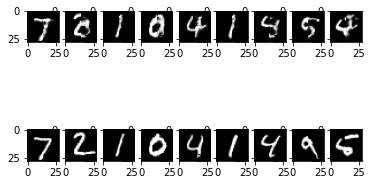

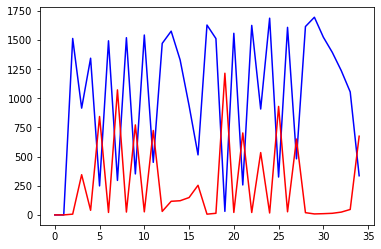

3.2464632987976074#3.2947068214416504#127.97853088378906#127.97918701171875#127.67926025390625#127.68528747558594#127.96052551269531#127.96080017089844#127.955322265625#127.955810546875#85.48362731933594#86.63218688964844#127.29603576660156#127.30109405517578#127.99751281738281#127.99752807617188#127.99980163574219#127.99980163574219#127.99441528320312#127.99455261230469#127.96162414550781#127.96112060546875#0.5344130992889404#0.5452499985694885#128.0#128.0#127.99996948242188#127.99996948242188#127.98245239257812#127.98265075683594#39.414852142333984#39.50672149658203#127.85227966308594#127.84730529785156#127.99095153808594#127.99037170410156#1.0587024688720703#1.0494635105133057#127.99786376953125#127.99851989746094#127.8429183959961#127.84258270263672#127.26456451416016#127.26260375976562#0.7274766564369202#0.7329845428466797#127.97154998779297#127.9704360961914#24.05784034729004#24.414371490478516#126.67723083496094#126.74380493164062#127.99725341796875#127.99734497070312#127.959625

<Figure size 432x288 with 0 Axes>

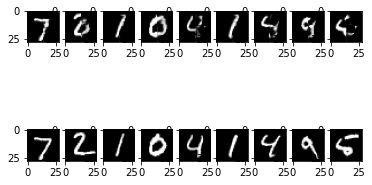

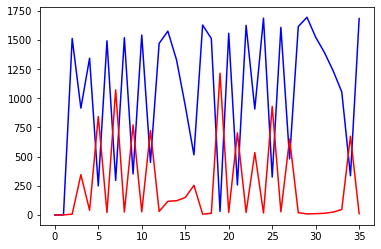

80.47740936279297#80.65428161621094#127.98966979980469#127.98997497558594#127.63008880615234#127.63400268554688#127.95649719238281#127.95523071289062#127.77568054199219#127.79021453857422#127.73562622070312#127.74610900878906#127.99700927734375#127.99684143066406#127.99905395507812#127.99905395507812#127.99989318847656#127.99989318847656#127.66938781738281#127.65219116210938#127.9927978515625#127.99307250976562#112.05138397216797#113.16899108886719#127.99998474121094#127.99998474121094#127.11688232421875#127.13255310058594#127.9949951171875#127.99508666992188#127.75724792480469#127.79102325439453#127.64950561523438#127.63363647460938#127.96651458740234#127.96599578857422#124.14920043945312#124.25651550292969#128.0#128.0#127.99908447265625#127.99905395507812#127.38087463378906#127.38053131103516#122.91004943847656#123.38371276855469#125.07534790039062#125.09309387207031#127.95790100097656#127.96148681640625#127.98440551757812#127.98579406738281#127.96358489990234#127.9573974609375#127.9

<Figure size 432x288 with 0 Axes>

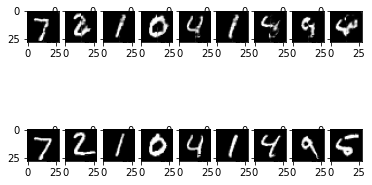

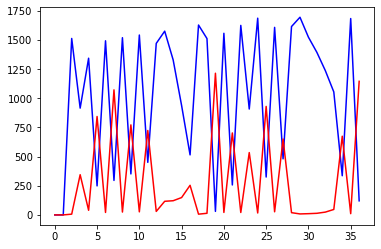

126.96277618408203#127.21004486083984#127.96819305419922#127.96862030029297#127.7528305053711#127.75154876708984#127.43380737304688#127.47434997558594#127.98822021484375#127.98823547363281#127.99723815917969#127.99742126464844#127.71992492675781#127.7183609008789#127.99855041503906#127.99861145019531#127.99986267089844#127.9998779296875#127.69632720947266#127.69904327392578#127.99989318847656#127.99989318847656#127.80123138427734#127.8062744140625#128.0#128.0#96.85710906982422#96.07506561279297#127.99807739257812#127.99821472167969#127.98594665527344#127.98600769042969#125.97224426269531#125.84919738769531#127.8141860961914#127.79791259765625#127.48809051513672#127.42450714111328#128.0#128.0#127.99990844726562#127.99992370605469#127.34564971923828#127.3038101196289#126.43292236328125#126.2500228881836#119.33718872070312#118.53314208984375#127.98121643066406#127.98153686523438#127.99468994140625#127.99468994140625#127.91377258300781#127.9184341430664#127.9952392578125#127.99539184570312

<Figure size 432x288 with 0 Axes>

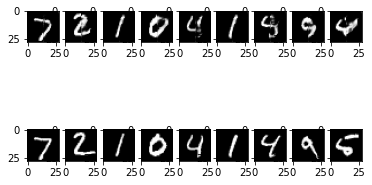

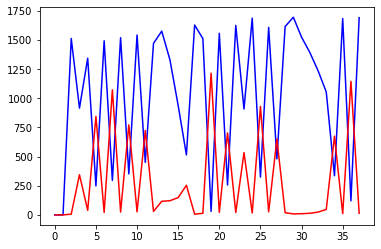

127.99870300292969#127.99867248535156#127.23880767822266#127.18159484863281#123.30558776855469#123.14678955078125#127.95654296875#127.95375061035156#127.96524810791016#127.9660415649414#128.0#128.0#127.94024658203125#127.93858337402344#127.99983215332031#127.99981689453125#127.99967956542969#127.99966430664062#111.48841857910156#112.1603775024414#127.99998474121094#127.99998474121094#127.91336059570312#127.91516876220703#127.99990844726562#127.99990844726562#124.00660705566406#123.9243392944336#127.93000030517578#127.92967987060547#126.32454681396484#126.30810546875#127.81843566894531#127.82418823242188#127.42990112304688#127.43739318847656#125.28716278076172#125.407958984375#117.80455017089844#117.77638244628906#127.99671936035156#127.9967041015625#127.73458862304688#127.73767852783203#124.3483657836914#124.41889953613281#120.7837905883789#120.81926727294922#127.99674987792969#127.99678039550781#123.15260314941406#123.19444274902344#127.99752807617188#127.99748229980469#127.6503295898

<Figure size 432x288 with 0 Axes>

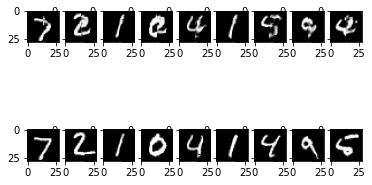

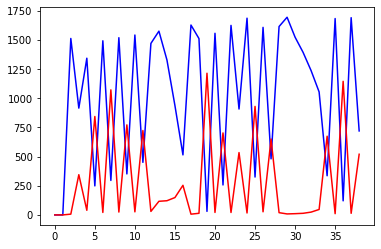

127.98277282714844#127.98324584960938#128.0#128.0#120.87200927734375#120.8029556274414#83.5188217163086#83.81976318359375#127.80399322509766#127.8134765625#128.0#128.0#127.819091796875#127.82105255126953#126.9369888305664#126.94306182861328#127.97882080078125#127.97911071777344#127.99998474121094#127.99998474121094#128.0#128.0#107.36904907226562#107.28559875488281#127.99533081054688#127.99530029296875#127.50457763671875#127.50291442871094#117.82012939453125#117.94861602783203#127.55857849121094#127.56561279296875#127.75047302246094#127.75598907470703#127.04798126220703#127.09228515625#119.47669219970703#119.75110626220703#126.25458526611328#126.3177490234375#125.86490631103516#126.2903823852539#127.823486328125#127.82902526855469#119.08583068847656#120.0177230834961#126.6849594116211#126.72398376464844#127.2322769165039#127.2578353881836#121.28395080566406#122.18638610839844#113.43882751464844#115.6170425415039#125.46746826171875#125.69942474365234#126.61219787597656#126.76667022705078

<Figure size 432x288 with 0 Axes>

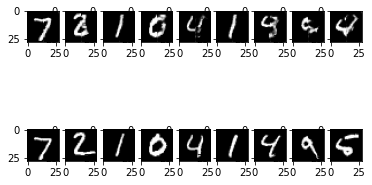

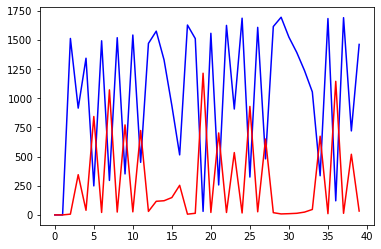

106.62020874023438#106.11767578125#127.98689270019531#127.98472595214844#79.4372329711914#78.30136108398438#127.22391510009766#127.1802978515625#127.99989318847656#127.99989318847656#127.95112609863281#127.95188903808594#126.62539672851562#126.63374328613281#127.99845886230469#127.99835205078125#127.99943542480469#127.9993896484375#127.75281524658203#127.74370574951172#127.99411010742188#127.99415588378906#127.99703979492188#127.99713134765625#127.99822998046875#127.99824523925781#0.0002449296589475125#0.00023162555589806288#127.82759094238281#127.82830810546875#127.99273681640625#127.99284362792969#1.69789719581604#1.670454740524292#127.89002990722656#127.89089965820312#127.99807739257812#127.99810791015625#127.9072036743164#127.9076156616211#127.95124816894531#127.95082092285156#50.46111297607422#50.43064880371094#127.99740600585938#127.9974365234375#127.5691909790039#127.58039093017578#127.99885559082031#127.9989013671875#127.20867156982422#127.2122573852539#127.99980163574219#127.9

<Figure size 432x288 with 0 Axes>

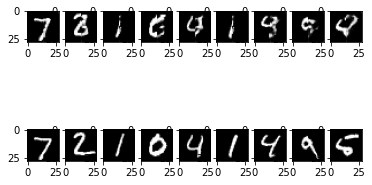

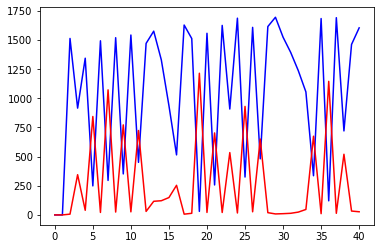

125.58404541015625#125.5946044921875#127.99676513671875#127.99673461914062#118.14285278320312#118.17231750488281#127.93277740478516#127.9331283569336#127.99688720703125#127.99679565429688#127.9942626953125#127.99424743652344#127.60990905761719#127.60989379882812#127.99961853027344#127.99961853027344#127.99787902832031#127.99786376953125#127.99850463867188#127.99850463867188#128.0#128.0#127.9925537109375#127.99249267578125#127.9864501953125#127.98696899414062#20.959598541259766#21.746337890625#127.86062622070312#127.86090087890625#127.9653091430664#127.96503448486328#63.510231018066406#63.771568298339844#128.0#128.0#127.99850463867188#127.99848937988281#127.9984130859375#127.9984130859375#127.96245574951172#127.96240997314453#111.1474609375#111.1175308227539#127.99905395507812#127.99905395507812#127.99955749511719#127.99955749511719#127.99923706054688#127.99923706054688#127.17245483398438#127.16239166259766#127.99996948242188#127.99996948242188#127.96379852294922#127.9636001586914#127.7

<Figure size 432x288 with 0 Axes>

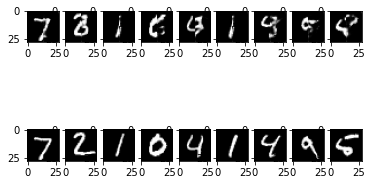

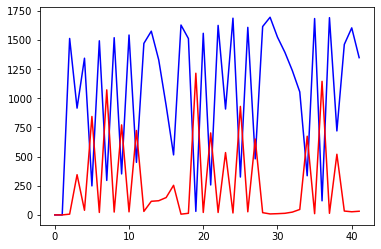

126.2905502319336#126.2782974243164#127.9450912475586#127.94463348388672#65.60235595703125#65.35240173339844#127.98391723632812#127.98385620117188#127.9814453125#127.98127746582031#127.98600769042969#127.98594665527344#127.64186096191406#127.64674377441406#127.99998474121094#127.99998474121094#127.99996948242188#127.99996948242188#127.98855590820312#127.98844909667969#128.0#128.0#127.99200439453125#127.99192810058594#127.987060546875#127.98692321777344#122.96369171142578#122.95915985107422#127.97675323486328#127.97692108154297#127.99169921875#127.99165344238281#24.667993545532227#24.213817596435547#128.0#128.0#127.99606323242188#127.99600219726562#127.98739624023438#127.98735046386719#127.99856567382812#127.99858093261719#19.529037475585938#19.102794647216797#127.99922180175781#127.99920654296875#127.99986267089844#127.99986267089844#127.99444580078125#127.99440002441406#126.9315414428711#126.93077850341797#128.0#128.0#127.96144104003906#127.96127319335938#127.97167205810547#127.971809

<Figure size 432x288 with 0 Axes>

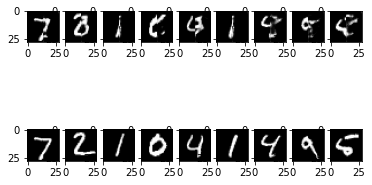

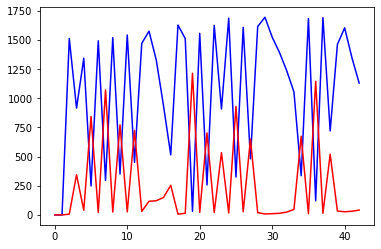

124.28392028808594#124.29316711425781#127.9404296875#127.94059753417969#11.400544166564941#11.244831085205078#127.99531555175781#127.9952392578125#127.96990203857422#127.96961212158203#127.98370361328125#127.98373413085938#126.7057113647461#126.72164916992188#128.0#128.0#128.0#128.0#127.97444915771484#127.97400665283203#128.0#128.0#127.99533081054688#127.99533081054688#127.997802734375#127.99783325195312#110.43927001953125#109.55091857910156#127.99801635742188#127.99801635742188#127.99688720703125#127.996826171875#12.888941764831543#12.75058364868164#127.99996948242188#127.99996948242188#127.99046325683594#127.99043273925781#127.9754409790039#127.9754867553711#127.99986267089844#127.99986267089844#3.7808785438537598#3.768531084060669#127.99932861328125#127.99932861328125#127.99980163574219#127.99980163574219#127.9500961303711#127.9497299194336#127.76676940917969#127.76321411132812#128.0#128.0#127.98484802246094#127.98475646972656#127.99928283691406#127.99928283691406#32.63676834106445#

<Figure size 432x288 with 0 Axes>

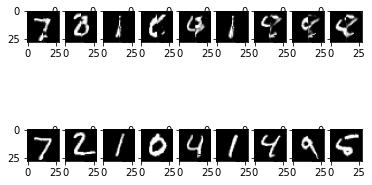

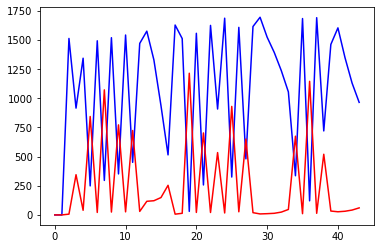

119.34685516357422#119.02850341796875#127.93757629394531#127.93759155273438#6.3569793701171875#6.342140197753906#127.96300506591797#127.96224212646484#127.91441345214844#127.91282653808594#127.66059875488281#127.65727996826172#37.161415100097656#37.741085052490234#127.99993896484375#127.99993896484375#127.99993896484375#127.99993896484375#127.94585418701172#127.94499969482422#128.0#128.0#127.98052978515625#127.97999572753906#127.99763488769531#127.9976806640625#101.8222427368164#101.21883392333984#127.99716186523438#127.99717712402344#127.97966003417969#127.97953796386719#7.500410556793213#7.481415271759033#128.0#128.0#127.97216033935547#127.97240447998047#127.99844360351562#127.99847412109375#127.99989318847656#127.99989318847656#1.1925832033157349#1.190895438194275#127.99688720703125#127.99687194824219#127.99998474121094#127.99998474121094#127.7116928100586#127.70790100097656#127.59447479248047#127.59172821044922#128.0#128.0#127.95809936523438#127.95793151855469#127.99983215332031#12

<Figure size 432x288 with 0 Axes>

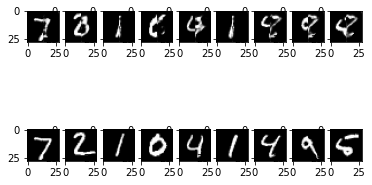

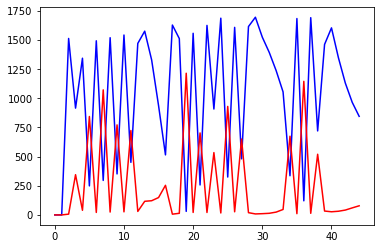

62.891544342041016#62.80318832397461#127.96492767333984#127.96456146240234#1.0300637483596802#1.0370161533355713#127.98495483398438#127.98452758789062#127.67919921875#127.67549133300781#127.82850646972656#127.82896423339844#3.287039279937744#3.318081855773926#127.99998474121094#127.99998474121094#127.99981689453125#127.99981689453125#127.78124237060547#127.78004455566406#127.99984741210938#127.99984741210938#127.96678924560547#127.9670639038086#127.99867248535156#127.99867248535156#3.848498582839966#3.761669635772705#127.99522399902344#127.99520874023438#127.9495620727539#127.94933319091797#0.8779289126396179#0.8771779537200928#128.0#128.0#127.91175842285156#127.91145324707031#127.99174499511719#127.9915771484375#127.99978637695312#127.99978637695312#0.2516113519668579#0.2523016333580017#127.99726867675781#127.99716186523438#127.99992370605469#127.99992370605469#119.83819580078125#119.60429382324219#127.78089141845703#127.77344512939453#128.0#128.0#127.90790557861328#127.90731048583984

<Figure size 432x288 with 0 Axes>

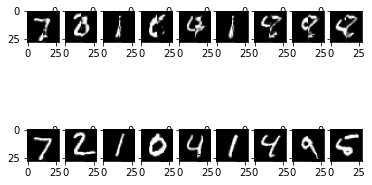

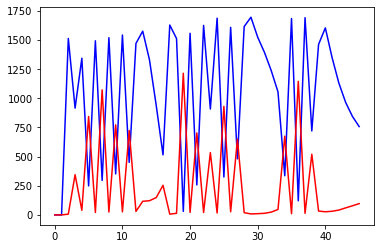

33.188724517822266#33.56551742553711#127.91744232177734#127.91883087158203#0.38853082060813904#0.3964141309261322#127.99073791503906#127.99078369140625#127.5628662109375#127.55635070800781#127.93934631347656#127.94049072265625#2.3218603134155273#2.350645065307617#127.99993896484375#127.99993896484375#127.99879455566406#127.99874877929688#127.6240005493164#127.62732696533203#127.9971923828125#127.997314453125#127.848388671875#127.84819030761719#127.99847412109375#127.99847412109375#3.283900737762451#3.388216018676758#127.9798583984375#127.97911071777344#127.81378173828125#127.81292724609375#1.2563669681549072#1.2539490461349487#128.0#128.0#127.73633575439453#127.73648834228516#127.98675537109375#127.98643493652344#127.99948120117188#127.99948120117188#0.20181883871555328#0.2031112164258957#127.99310302734375#127.99288940429688#128.0#128.0#85.7688980102539#85.47759246826172#127.71121215820312#127.70970153808594#128.0#128.0#127.11199188232422#127.0986328125#127.9996337890625#127.999633789

<Figure size 432x288 with 0 Axes>

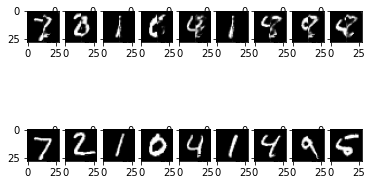

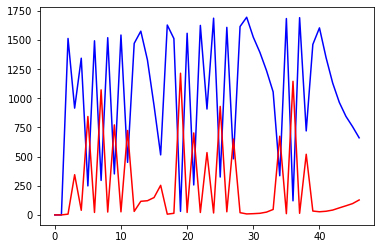

9.874253273010254#9.8505859375#127.99737548828125#127.99745178222656#8.330621719360352#8.633469581604004#127.97866821289062#127.97805786132812#127.5262680053711#127.53838348388672#127.96392059326172#127.96153259277344#5.517702579498291#5.7280144691467285#127.99996948242188#127.99996948242188#127.99778747558594#127.99777221679688#127.73651885986328#127.74518585205078#127.99986267089844#127.99989318847656#127.91241455078125#127.91091918945312#127.22351837158203#127.17652130126953#45.04212188720703#45.7972526550293#127.92017364501953#127.9194107055664#127.43730163574219#127.42626190185547#104.58264923095703#104.4801254272461#127.99397277832031#127.99464416503906#127.73616790771484#127.73702239990234#127.82864379882812#127.8319320678711#127.99960327148438#127.99958801269531#92.5123062133789#92.15412902832031#127.97144317626953#127.97118377685547#127.99961853027344#127.99964904785156#28.069480895996094#28.314722061157227#127.913818359375#127.91290283203125#128.0#128.0#127.04497528076172#127

<Figure size 432x288 with 0 Axes>

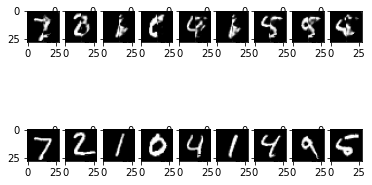

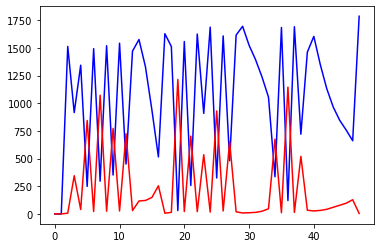

122.10501861572266#122.08793640136719#127.99641418457031#127.99650573730469#44.870140075683594#44.186767578125#127.99365234375#127.99362182617188#127.90874481201172#127.90723419189453#127.15615844726562#127.14994049072266#17.629165649414062#17.944074630737305#127.99974060058594#127.99974060058594#127.99905395507812#127.99905395507812#127.97721099853516#127.97777557373047#127.9901123046875#127.98980712890625#127.99436950683594#127.99446105957031#127.93314361572266#127.93435668945312#0.2993704378604889#0.30555668473243713#127.99838256835938#127.99839782714844#127.96078491210938#127.96084594726562#25.15776252746582#25.181455612182617#127.99998474121094#127.99998474121094#127.95184326171875#127.95193481445312#127.99128723144531#127.99136352539062#127.99931335449219#127.99932861328125#32.64497375488281#32.36286163330078#127.99980163574219#127.99981689453125#127.99992370605469#127.99992370605469#124.55367279052734#124.55364227294922#127.99261474609375#127.99281311035156#128.0#128.0#127.96156

<Figure size 432x288 with 0 Axes>

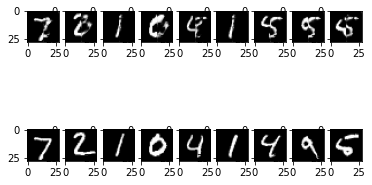

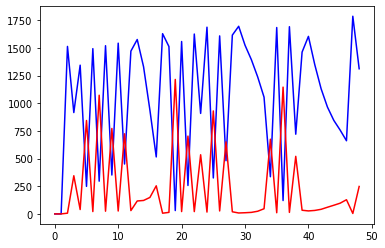

127.51581573486328#127.51738739013672#127.98648071289062#127.98677062988281#119.38605499267578#119.33600616455078#127.87244415283203#127.87271881103516#127.9743881225586#127.97443389892578#127.93760681152344#127.93794250488281#43.803646087646484#43.572635650634766#127.91915130615234#127.91938018798828#127.94237518310547#127.94251251220703#127.90801239013672#127.9087905883789#0.009690668433904648#0.009660709649324417#127.9998779296875#127.9998779296875#127.99215698242188#127.9921875#0.19120967388153076#0.18989711999893188#127.99398803710938#127.99397277832031#127.99992370605469#127.99992370605469#7.528543472290039#7.469045162200928#127.9620590209961#127.96221160888672#127.99957275390625#127.99957275390625#127.99981689453125#127.99981689453125#127.9227294921875#127.92282104492188#103.71343231201172#103.65171813964844#128.0#128.0#117.19816589355469#117.21249389648438#127.9629898071289#127.9630355834961#127.97687530517578#127.97679901123047#127.97241973876953#127.97228240966797#127.9846801

<Figure size 432x288 with 0 Axes>

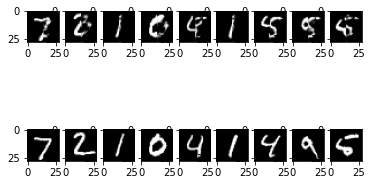

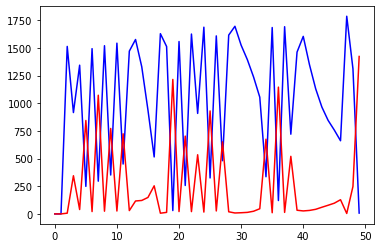

127.63758087158203#127.63851928710938#127.99436950683594#127.99453735351562#115.70081329345703#115.09925079345703#127.7994155883789#127.80204772949219#127.9631576538086#127.9608154296875#127.96168518066406#127.96283721923828#3.8420450687408447#3.582859516143799#127.94306182861328#127.94463348388672#127.95439147949219#127.95533752441406#127.97693634033203#127.97753143310547#0.004453863482922316#0.004205520264804363#127.99989318847656#127.99989318847656#127.99554443359375#127.99560546875#0.03382602334022522#0.03331097587943077#127.99349975585938#127.99356079101562#127.99992370605469#127.99992370605469#2.421550750732422#2.3641889095306396#127.87519836425781#127.87244415283203#127.99992370605469#127.99992370605469#128.0#128.0#127.96288299560547#127.96331024169922#58.15685272216797#58.3930778503418#128.0#128.0#110.0929946899414#110.27999114990234#127.96417999267578#127.96358489990234#127.97014617919922#127.9699478149414#127.93547058105469#127.93670654296875#127.98918151855469#127.9892272949

<Figure size 432x288 with 0 Axes>

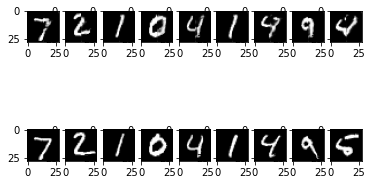

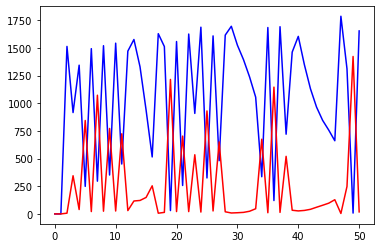

118.88137817382812#118.3470230102539#127.99513244628906#127.995361328125#85.43606567382812#84.74811553955078#127.30625915527344#127.31181335449219#127.8741455078125#127.8665771484375#127.67047882080078#127.65304565429688#128.0#128.0#123.6481704711914#123.82738494873047#124.62420654296875#124.6739501953125#127.99685668945312#127.996337890625#128.0#128.0#127.3233413696289#127.33293151855469#127.98580932617188#127.98344421386719#0.000998661620542407#0.000877171871252358#126.42884063720703#126.44181060791016#59.04335021972656#57.998905181884766#0.6234333515167236#0.6071552634239197#127.33068084716797#127.24141693115234#127.3576889038086#127.3517074584961#127.99971008300781#127.99967956542969#103.48271179199219#103.13997650146484#6.40106725692749#6.400540828704834#127.79988861083984#127.80529022216797#127.99818420410156#127.99798583984375#125.33319854736328#125.32506561279297#124.77699279785156#124.78105163574219#127.58163452148438#127.57901000976562#126.82422637939453#126.84593200683594#68

<Figure size 432x288 with 0 Axes>

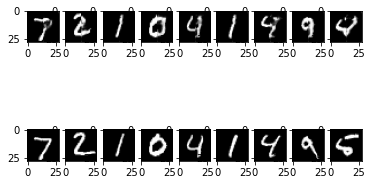

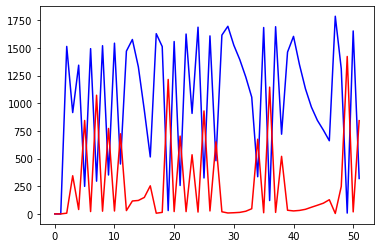

117.5418701171875#117.6335220336914#127.7286376953125#127.7290267944336#35.69428253173828#34.78632736206055#108.71041870117188#107.6314468383789#127.71011352539062#127.69293975830078#97.3199691772461#96.04362487792969#127.99995422363281#127.99995422363281#48.58894348144531#47.01924514770508#67.89482879638672#66.26932525634766#127.08512115478516#127.07811737060547#128.0#128.0#2.1075103282928467#2.0860018730163574#72.03472900390625#71.43736267089844#0.10263343900442123#0.0957372635602951#100.7734603881836#100.7503433227539#7.533697128295898#7.6381378173828125#107.84219360351562#105.78861236572266#127.45513153076172#127.51713562011719#3.5911731719970703#3.5845680236816406#127.99908447265625#127.99916076660156#14.922577857971191#15.177702903747559#5.102966785430908#5.104409694671631#1.6151446104049683#1.5995581150054932#127.98707580566406#127.98744201660156#127.78311157226562#127.75335693359375#24.46550750732422#24.247365951538086#126.73371887207031#126.75999450683594#118.16987609863281#11

<Figure size 432x288 with 0 Axes>

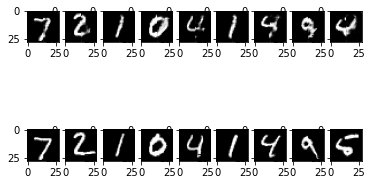

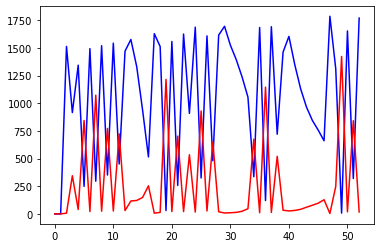

104.38656616210938#104.75662994384766#127.97637176513672#127.97672271728516#112.9776611328125#112.68186950683594#126.26001739501953#126.28305053710938#127.87139129638672#127.8680419921875#127.82636260986328#127.84127807617188#127.9986572265625#127.9986572265625#127.23945617675781#127.28640747070312#126.72480773925781#126.83332061767578#127.94550323486328#127.95310974121094#127.99971008300781#127.99958801269531#123.81900787353516#124.45272827148438#127.99800109863281#127.99851989746094#16.874284744262695#17.025075912475586#127.9539794921875#127.9581298828125#118.50951385498047#119.3851089477539#126.94746398925781#127.0394287109375#127.9989013671875#127.99879455566406#125.8089828491211#126.1165542602539#127.986328125#127.98390197753906#123.05753326416016#123.53025817871094#75.77073669433594#75.72206115722656#127.74655151367188#127.77008056640625#127.98185729980469#127.97930908203125#127.4751205444336#127.4806137084961#126.66221618652344#126.73616027832031#127.98762512207031#127.987640380

<Figure size 432x288 with 0 Axes>

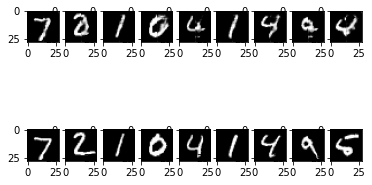

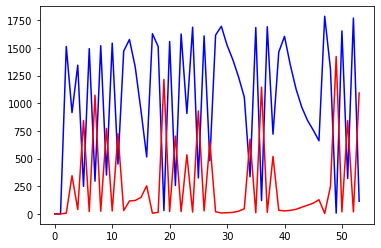

118.26099395751953#118.31285858154297#127.99990844726562#127.99990844726562#91.05644989013672#91.2610855102539#127.43721008300781#127.43321228027344#127.93429565429688#127.9349365234375#127.99639892578125#127.99641418457031#127.98188781738281#127.98161315917969#127.8544921875#127.85319519042969#127.97026824951172#127.9704360961914#127.99989318847656#127.99989318847656#128.0#128.0#127.92050170898438#127.92204284667969#127.98921203613281#127.98890686035156#119.07756805419922#119.1116714477539#127.79405975341797#127.79138946533203#127.44245910644531#127.45853424072266#127.77021789550781#127.77660369873047#127.97237396240234#127.97347259521484#127.86859130859375#127.86683654785156#127.98243713378906#127.98275756835938#127.39154815673828#127.33598327636719#107.83039855957031#108.06777954101562#127.98234558105469#127.9815673828125#127.9962158203125#127.99623107910156#127.72881317138672#127.72154235839844#127.6865005493164#127.65685272216797#127.99627685546875#127.99650573730469#127.920379638

<Figure size 432x288 with 0 Axes>

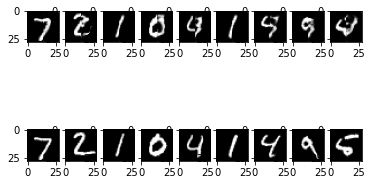

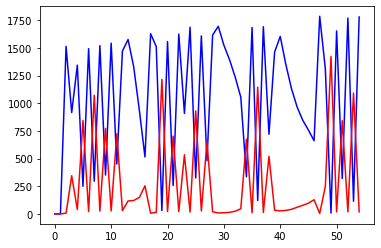

123.68876647949219#123.69300079345703#127.9931640625#127.99299621582031#7.3341498374938965#7.185208797454834#121.95252227783203#121.8983154296875#126.44725799560547#126.44404602050781#127.98336791992188#127.98356628417969#127.99868774414062#127.9986572265625#121.31218719482422#121.52986907958984#127.78096771240234#127.78641510009766#127.98280334472656#127.9814453125#128.0#128.0#126.58968353271484#126.72502899169922#127.99998474121094#127.99998474121094#87.07649993896484#88.58570098876953#126.77991485595703#126.79791259765625#127.681884765625#127.68291473388672#124.5687255859375#124.5948486328125#127.33847045898438#127.3128662109375#127.823486328125#127.82689666748047#127.98475646972656#127.98434448242188#101.13211822509766#101.15182495117188#9.054835319519043#9.054839134216309#127.92509460449219#127.92585754394531#127.89412689208984#127.89241027832031#126.96904754638672#126.98137664794922#1.9746440649032593#1.9327236413955688#127.883056640625#127.88307189941406#127.6323471069336#127.64

<Figure size 432x288 with 0 Axes>

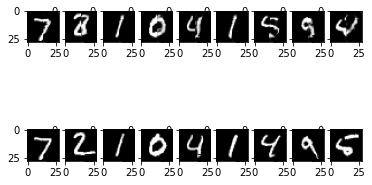

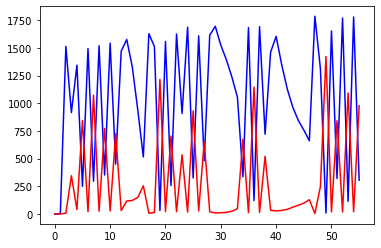

109.31836700439453#109.68720245361328#127.99406433105469#127.99412536621094#14.428295135498047#15.334258079528809#108.26898193359375#108.14224243164062#127.98786926269531#127.98770141601562#127.95182800292969#127.95127868652344#127.98750305175781#127.98780822753906#125.97687530517578#125.98003387451172#127.95326232910156#127.95280456542969#126.97367095947266#126.95410919189453#128.0#128.0#127.99514770507812#127.99519348144531#128.0#128.0#89.26789093017578#89.38372039794922#127.76612854003906#127.76355743408203#127.8380355834961#127.83514404296875#127.75287628173828#127.74422454833984#107.37598419189453#107.31525421142578#127.99600219726562#127.99603271484375#127.98916625976562#127.98965454101562#126.4219970703125#126.41648864746094#12.426434516906738#12.051076889038086#127.99913024902344#127.99916076660156#126.16456604003906#126.2137451171875#127.99935913085938#127.99946594238281#3.487149238586426#3.366868734359741#127.69022369384766#127.73697662353516#127.87535095214844#127.8732452392

In [ ]:
G_loss_runs = [0, 0]
D_loss_runs = [0, 0]

discriminator_skipt_index = 6

criterion = torch.nn.BCELoss()
for epoch in range(epoch_numbers):
    epoch_start_time = time.time()
    G_loss_runs.append(0)
    g_count = 1
    D_loss_runs.append(0)
    d_count = 1
    i = 0
    z = 0
    for i, (data, data_target) in enumerate(zip(generator_train_loader, generator_train_loader_target)):
        batch_start_time = time.time()

        data_target_one_hot = torch_functional.one_hot(data_target.to(torch.int64))
        data_target_one_hot = data_target_one_hot.to(device)

        X = data.to(device).unsqueeze(1)
        left_half_flattened = X[:, :, :, :14]
        mb_size = X.size(0)

        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)

        z = generate_random_gaussian(mb_size, initial_random_base_dim).to(device)

        # Training Discriminator And Generator
        
        generated_full_image = generator(left_half_flattened, z, data_target_one_hot)
        D_fake = discriminator(generated_full_image, data_target_one_hot)

        G_loss = criterion(D_fake, one_labels)

        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        g_count += 1
        G_loss_runs[-1] += G_loss.item()

        # if i % discriminator_skipt_index == 0:
        # if epoch <= 5 :
        # if epoch % ((epoch+3)//3) == 0:
        # if epoch < random.random()*75:
        if G_loss_runs[-2] - D_loss_runs[-2] <= 600:
          
          # with torch.no_grad():
          generated_full_image = generator(left_half_flattened, z, data_target_one_hot)

          D_fake = discriminator(generated_full_image, data_target_one_hot)

          D_real = discriminator(X, data_target_one_hot)

          D_real_loss = criterion(D_real, one_labels)
          D_fake_loss = criterion(D_fake, zero_labels)
          D_loss = (D_real_loss + D_fake_loss)

          d_opt.zero_grad()
          D_loss.backward()
          d_opt.step()
          d_count += 1
          D_loss_runs[-1] += D_loss.item()
        else:
          with torch.no_grad():
            generated_full_image = generator(left_half_flattened, z, data_target_one_hot)
            D_fake = discriminator(generated_full_image, data_target_one_hot)
            D_real = discriminator(X, data_target_one_hot)
            D_real_loss = criterion(D_real, one_labels)
            D_fake_loss = criterion(D_fake, zero_labels)
            D_loss = (D_real_loss + D_fake_loss)
            d_count += 1
            D_loss_runs[-1] += D_loss.item()
        


    G_loss_runs[-1] += G_loss_runs[-1] / g_count
    D_loss_runs[-1] += D_loss_runs[-1] / d_count
    print()
    print("epoch:", epoch, "in: ", int(time.time() - epoch_start_time), 'sec')

    show_generated_on_sample()
    show_training_charts()


# Best Epoch
48